## <ins>Import dependencies

In [120]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score

import warnings
warnings.filterwarnings("ignore")

## <ins>Read in the data from the preprocessed csv

In [69]:
# Get the current directory of the notebook
current_dir = os.path.dirname(os.path.abspath(""))

# Navigate up two levels to reach the Project4 directory
project_dir = os.path.dirname(current_dir)

# Construct the absolute path to the CSV file
file_path = os.path.join(project_dir, "data/df_output/df_cleaned.csv")

# Load the CSV file
df_data = pd.read_csv(file_path)

# Show the df
df_data.head(2)

,IDUSGS,PLAYTYPE,WELLTYPE,FORMSIMPLE,TDS,LATITUDE,LONGITUDE,STATE,COUNTY,PROVINCE,...,FeTot,K,Li,Mg,Na,SO4,Sr,Zn,CHARGEBAL,BASIN_CATEGORY
0,63,Shale,Shale Gas,Marcellus,54800.0,40.441658,-79.986932,Pennsylvania,Allegheny,Appalachian Basin,...,27.40,0.0,21.5,295.0,12000.0,105.0,736.5,0.0839,-10.5,Appalachian
1,64,Shale,Shale Gas,Marcellus,26100.0,40.441658,-79.986932,Pennsylvania,Allegheny,Appalachian Basin,...,6.47,0.0,12.5,188.0,6920.0,116.0,215.0,0.0321,-3.0,Appalachian


In [70]:
df_data.columns

Index(['IDUSGS', 'PLAYTYPE', 'WELLTYPE', 'FORMSIMPLE', 'TDS', 'LATITUDE',
       'LONGITUDE', 'STATE', 'COUNTY', 'PROVINCE', 'REGION', 'WELLNAME', 'API',
       'DEPTHUPPER', 'DEPTHLOWER', 'PERIOD', 'DATESAMPLE', 'PH', 'B', 'Ba',
       'Br', 'HCO3', 'Ca', 'Cl', 'FeTot', 'K', 'Li', 'Mg', 'Na', 'SO4', 'Sr',
       'Zn', 'CHARGEBAL', 'BASIN_CATEGORY'],
      dtype='object')

In [71]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60658 entries, 0 to 60657
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   IDUSGS          60658 non-null  int64  
 1   PLAYTYPE        60658 non-null  object 
 2   WELLTYPE        60658 non-null  object 
 3   FORMSIMPLE      60658 non-null  object 
 4   TDS             60658 non-null  float64
 5   LATITUDE        60658 non-null  float64
 6   LONGITUDE       60658 non-null  float64
 7   STATE           60658 non-null  object 
 8   COUNTY          60026 non-null  object 
 9   PROVINCE        60658 non-null  object 
 10  REGION          60658 non-null  object 
 11  WELLNAME        54693 non-null  object 
 12  API             34447 non-null  float64
 13  DEPTHUPPER      47354 non-null  float64
 14  DEPTHLOWER      40757 non-null  float64
 15  PERIOD          48402 non-null  object 
 16  DATESAMPLE      46382 non-null  object 
 17  PH              45174 non-null 

## <ins>Generate KNN regression models for each basin for consideration

### ROUND 0 | Running on full data ILO by basin first to establish some basic logic as a starting point

In [72]:
# Drop unnecessary columns
# columns_to_drop = ['IDUSGS', 'PERIOD', 'DATESAMPLE', 'API']
columns_to_drop = ['IDUSGS', 'PERIOD', 'DATESAMPLE', 'API', 'Ba', 'Zn', 'B', 'FeTot', 'DEPTHLOWER', 'Sr', 'Br', 'HCO3']
df = df_data.drop(columns_to_drop, axis=1)
df.head(2)

,PLAYTYPE,WELLTYPE,FORMSIMPLE,TDS,LATITUDE,LONGITUDE,STATE,COUNTY,PROVINCE,REGION,...,PH,Ca,Cl,K,Li,Mg,Na,SO4,CHARGEBAL,BASIN_CATEGORY
0,Shale,Shale Gas,Marcellus,54800.0,40.441658,-79.986932,Pennsylvania,Allegheny,Appalachian Basin,Eastern,...,NaN,3140.0,31300.0,0.0,21.5,295.0,12000.0,105.0,-10.5,Appalachian
1,Shale,Shale Gas,Marcellus,26100.0,40.441658,-79.986932,Pennsylvania,Allegheny,Appalachian Basin,Eastern,...,NaN,1790.0,15300.0,0.0,12.5,188.0,6920.0,116.0,-3.0,Appalachian


In [73]:
df.dropna(subset=['Li'], inplace=True)
df.head(2)

,PLAYTYPE,WELLTYPE,FORMSIMPLE,TDS,LATITUDE,LONGITUDE,STATE,COUNTY,PROVINCE,REGION,...,PH,Ca,Cl,K,Li,Mg,Na,SO4,CHARGEBAL,BASIN_CATEGORY
0,Shale,Shale Gas,Marcellus,54800.0,40.441658,-79.986932,Pennsylvania,Allegheny,Appalachian Basin,Eastern,...,NaN,3140.0,31300.0,0.0,21.5,295.0,12000.0,105.0,-10.5,Appalachian
1,Shale,Shale Gas,Marcellus,26100.0,40.441658,-79.986932,Pennsylvania,Allegheny,Appalachian Basin,Eastern,...,NaN,1790.0,15300.0,0.0,12.5,188.0,6920.0,116.0,-3.0,Appalachian


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4131 entries, 0 to 60657
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PLAYTYPE        4131 non-null   object 
 1   WELLTYPE        4131 non-null   object 
 2   FORMSIMPLE      4131 non-null   object 
 3   TDS             4131 non-null   float64
 4   LATITUDE        4131 non-null   float64
 5   LONGITUDE       4131 non-null   float64
 6   STATE           4131 non-null   object 
 7   COUNTY          4011 non-null   object 
 8   PROVINCE        4131 non-null   object 
 9   REGION          4131 non-null   object 
 10  WELLNAME        3270 non-null   object 
 11  DEPTHUPPER      3293 non-null   float64
 12  PH              3123 non-null   float64
 13  Ca              4118 non-null   float64
 14  Cl              4131 non-null   float64
 15  K               4131 non-null   float64
 16  Li              4131 non-null   float64
 17  Mg              4093 non-null   float

In [75]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2142 entries, 285 to 59982
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PLAYTYPE        2142 non-null   object 
 1   WELLTYPE        2142 non-null   object 
 2   FORMSIMPLE      2142 non-null   object 
 3   TDS             2142 non-null   float64
 4   LATITUDE        2142 non-null   float64
 5   LONGITUDE       2142 non-null   float64
 6   STATE           2142 non-null   object 
 7   COUNTY          2142 non-null   object 
 8   PROVINCE        2142 non-null   object 
 9   REGION          2142 non-null   object 
 10  WELLNAME        2142 non-null   object 
 11  DEPTHUPPER      2142 non-null   float64
 12  PH              2142 non-null   float64
 13  Ca              2142 non-null   float64
 14  Cl              2142 non-null   float64
 15  K               2142 non-null   float64
 16  Li              2142 non-null   float64
 17  Mg              2142 non-null   flo

In [76]:
# One-hot encode categorical variables
categorical_columns = ['PLAYTYPE', 'WELLTYPE', 'FORMSIMPLE', 'STATE', 'COUNTY', 'PROVINCE', 'REGION', 'WELLNAME', 'BASIN_CATEGORY']
df = pd.get_dummies(df, columns=categorical_columns, dtype=int)
df.head(2)

,TDS,LATITUDE,LONGITUDE,DEPTHUPPER,PH,Ca,Cl,K,Li,Mg,...,BASIN_CATEGORY_Fort Worth,BASIN_CATEGORY_Great Plains,BASIN_CATEGORY_Gulf Coast,BASIN_CATEGORY_Illinois,BASIN_CATEGORY_Michigan,BASIN_CATEGORY_Oklahoma Platform,BASIN_CATEGORY_Pacific,BASIN_CATEGORY_Permian,BASIN_CATEGORY_Rocky Mountain,BASIN_CATEGORY_Williston
285,25200.0,29.55707,-97.78930,2582.0,6.5,1900.0,14000.0,130.0,7.7,580.0,...,0,0,1,0,0,0,0,0,0,0
286,127000.0,29.17289,-97.54256,11933.0,6.1,13000.0,76000.0,1100.0,120.0,1100.0,...,0,0,1,0,0,0,0,0,0,0


In [77]:
# Splitting the data into features (X) and the target variable (y)
y = df['Li'].copy()                   # Target variable
X = df.drop(columns=['Li']).copy()    # Features

In [78]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [79]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [80]:
# Define a range of k values to try
k_values = list(range(1, 21))

# Create a parameter grid
param_grid = {'n_neighbors': k_values}

# Perform grid search with cross-validation
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best k value
best_k = grid_search.best_params_['n_neighbors']
print("Best k value:", best_k)

Best k value: 2


In [81]:
# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("MSE of the best KNN model:", mse)
print("RMSE of the best KNN model:", rmse)

MSE of the best KNN model: 14952.269930870916
RMSE of the best KNN model: 122.27947469167063


In [82]:
# Calculate the variance of the target variable
target_variance = np.var(y_test)

# Print the variance, MSE, RMSE
print("Variance of the target variable:", target_variance)
print("MSE of the model:", mse)
print("RMSE of the model:", rmse)

# Compare the MSE to the variance
if mse < target_variance:
    print("The model's MSE is smaller than the variance of the target variable.")
    print("The model is capturing a significant portion of the variability in the target variable.")
else:
    print("The model's MSE is close to or larger than the variance of the target variable.")
    print("The model's performance may be limited compared to the variability of the target variable.")


Variance of the target variable: 14142.737286612884
MSE of the model: 14952.269930870916
RMSE of the model: 122.27947469167063
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.


MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 14142.737286612884
MSE of the model: 14952.269930870916
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 122.27947469167063
MAE of the best KNN model: 29.5347900466563
-------------------------------
Quantile regression loss:
Quantile 0.25: 1.0625
Quantile 0.5: 3.88
Quantile 0.75: 11.192499999999999
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 3.30%
±10%: 4.67%
±15%: 5.63%
±20%: 6.21%
±50%: 8.09%
Performance range: 1699.80
Minimum percentage difference: 0.00%
Maximum percentage difference: 15919.23%
-------------------------------


Cross-validation MSE scores: [1814.96931067 5906.54409175 3302.24780233 3716.17082867 2797.2231393 ]
Mean cross-validation MSE: 3507.4310345428653
-------------------------------
Feature importances are not available for this model.
-------------------------------


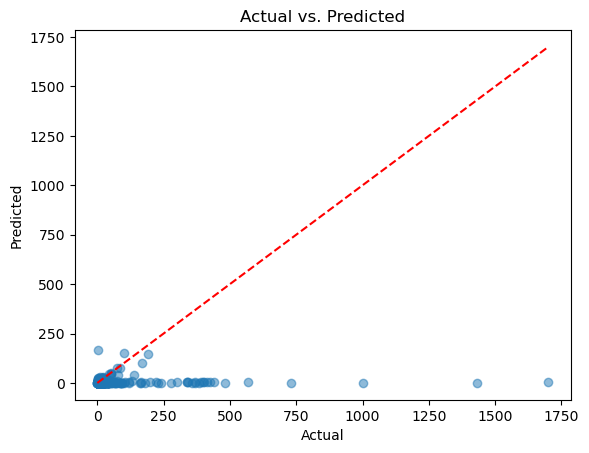

-------------------------------


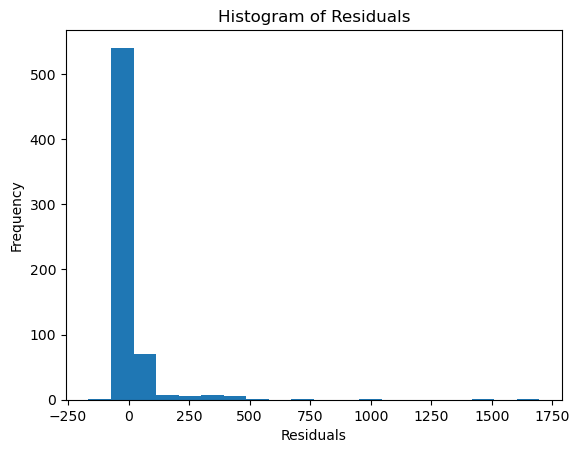

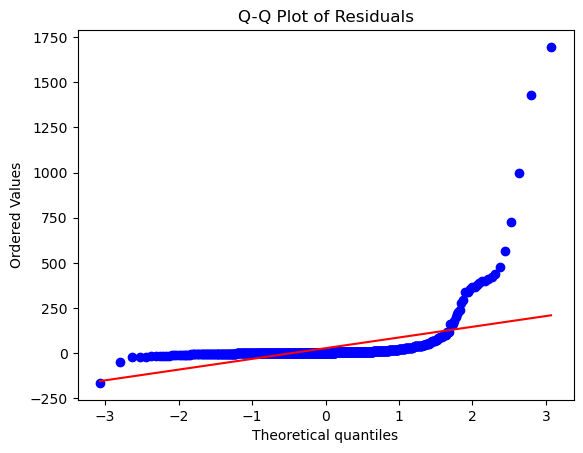

-------------------------------


In [83]:
'''Get all the performance metrics...'''

# Calculate the mean squared error and the root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate the variance of the target variable
target_variance = np.var(y_test)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Print the metrics
print("MODEL PERFORMANCE METRICS")
print('-------------------------------')
print("Variance of the target variable:", target_variance)
print("MSE of the model:", mse)
# Compare the MSE to the variance
if mse < target_variance:
    print("The model's MSE is smaller than the variance of the target variable.")
    print("The model is capturing a significant portion of the variability in the target variable.")
else:
    print("The model's MSE is close to or larger than the variance of the target variable.")
    print("The model's performance may be limited compared to the variability of the target variable.")
print("RMSE of the model:", rmse)
print("MAE of the best KNN model:", mae)
print('-------------------------------')

# Quantile regression loss at 25th, 50th, and 75th percentiles
quantiles = [0.25, 0.5, 0.75]
quantile_losses = [np.percentile(np.abs(y_test - y_pred), q * 100) for q in quantiles]
print("Quantile regression loss:")
for q, loss in zip(quantiles, quantile_losses):
    print(f"Quantile {q}: {loss}")
print('-------------------------------')

# Define tolerance levels
tolerance_levels = [5, 10, 15, 20, 50]  # Percentage tolerance levels
tolerances = {level: level / 100 * np.mean(y_test) for level in tolerance_levels}

# Calculate performance range
performance_range = np.max(y_test) - np.min(y_test)

# Initialize counters for each tolerance level
within_tolerance = {level: 0 for level in tolerance_levels}

# Calculate the percentage of predictions within each tolerance level
for level, tol in tolerances.items():
    within_tolerance[level] = np.mean(np.abs(y_test - y_pred) <= tol) * 10

# Print results
print(f"Percentage of predictions within different tolerance levels:")
for level in tolerance_levels:
    print(f"±{level}%: {within_tolerance[level]:.2f}%")
print(f"Performance range: {performance_range:.2f}")

# Calculate percentage differences between predicted and actual values
percentage_diff = (np.abs(y_pred - y_test) / y_test) * 100

# Calculate the actual percentage range
min_percentage_range = np.min(percentage_diff)
max_percentage_range = np.max(percentage_diff)

# Calculate the percentage of predictions within each tolerance level
within_tolerance = {level: np.mean(percentage_diff <= level) * 100 for level in tolerance_levels}

# Print results
print(f"Minimum percentage difference: {min_percentage_range:.2f}%")
print(f"Maximum percentage difference: {max_percentage_range:.2f}%")
print('-------------------------------')

# Perform k-fold cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive values
cv_scores = -cv_scores

# Print cross-validation scores
print("Cross-validation MSE scores:", cv_scores)
print("Mean cross-validation MSE:", np.mean(cv_scores))
print('-------------------------------')

# Access feature importances if applicable (e.g., for decision tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    # Print feature importances
    print("Feature importances:")
    for feature, importance in zip(X.columns, feature_importances):
        print(f"{feature}: {importance}")
else:
    print("Feature importances are not available for this model.")
print('-------------------------------')

# Scatter plot of actual vs. predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()
print('-------------------------------')

# Calculate residuals
residuals = y_test - y_pred

# Plot histogram of residuals
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Alternatively, you can also create a Q-Q plot of residuals
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()
print('-------------------------------')

### Establishing function for running models for each Basin given certain variable inputs

In [141]:
def generate_knn_models_by_basin(df, round, basins, columns_to_drop, categorical_columns, test_size, random_state, k_values):
    
    '''Finalize data preprocessing per input variables / requirements of KNN regression model'''

    # Drop unnecessary columns
    df_starting = df.drop(columns_to_drop, axis=1)
    
    # Create an empty list to store results for each basin
    results_list = []

    for basin in basins:
        
        print('===============================')
        print(f'{basin}')
        print('===============================')

        '''--------------------------------------------------------------------------------------------------------------'''
        '''Finalize data preprocessing per input variables / requirements of KNN regression model'''

        # Drop rows from anything that isn't the 'basin' at hand
        df_basin = df_starting[df_starting['BASIN_CATEGORY'] == basin]

        # Drop the 'BASIN_CATEGORY' column as it is no longer needed
        df_basin.drop('BASIN_CATEGORY', axis=1, inplace=True)

        # Drop null values in the 'Li' (target) column
        df_basin.dropna(subset=['Li'], inplace=True)

        # Drop any remaining null values
        df_basin.dropna(inplace=True)

        # Get the remaining number of rows
        num_rows = df_basin.shape[0]
        print("Number of data points: ", num_rows)

        if num_rows > 0:
            '''--------------------------------------------------------------------------------------------------------------'''
            '''Encode categorical features (if any)'''

            # One-hot encode categorical variables (if any); if none provided, this is skipped
            if categorical_columns:
                df_basin = pd.get_dummies(df_basin, columns=categorical_columns, dtype=int)

            '''--------------------------------------------------------------------------------------------------------------'''
            '''Split testing/training sets'''

            # Splitting the data into features (X) and the target variable (y)
            y = df_basin['Li'].copy()                   # Target variable
            X = df_basin.drop(columns=['Li']).copy()    # Features

            # Splitting the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
            
            '''--------------------------------------------------------------------------------------------------------------'''
            '''Scale features'''

            # Standardize features by removing the mean and scaling to unit variance
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            '''--------------------------------------------------------------------------------------------------------------'''
            '''Train & test model'''

            # Create a parameter grid
            param_grid = {'n_neighbors': k_values}

            # Determine the number of splits for cross-validation
            n_samples = X_train_scaled.shape[0]
            # Print the number of samples in the training dataset
            print("Number of samples in the training dataset:", n_samples)
            n_splits = min(5, n_samples)  # Use 5 splits or the number of samples, whichever is smaller
            n_splits = max(2, n_splits)  # Ensure there are at least 2 splits

            # Perform grid search with cross-validation
            grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=n_splits, scoring='neg_mean_squared_error')
            grid_search.fit(X_train_scaled, y_train)

            # Get the best k value
            best_k = grid_search.best_params_['n_neighbors']
            print("Best k value:", best_k)

            # Get the best model
            best_model = grid_search.best_estimator_

            # Evaluate the best model
            y_pred = best_model.predict(X_test_scaled)
            
            '''--------------------------------------------------------------------------------------------------------------'''
            '''Get all the performance metrics...'''

            # Calculate the mean squared error and the root mean squared error
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)

            # Calculate the variance of the target variable
            target_variance = np.var(y_test)

            # Calculate the mean absolute error
            mae = mean_absolute_error(y_test, y_pred)

            # Print the metrics
            print('-------------------------------')
            print("MODEL PERFORMANCE METRICS")
            print('-------------------------------')
            print("Variance of the target variable:", target_variance)
            print("MSE of the model:", mse)
            # Compare the MSE to the variance
            if mse < target_variance:
                print("The model's MSE is smaller than the variance of the target variable.")
                print("The model is capturing a significant portion of the variability in the target variable.")
            else:
                print("The model's MSE is close to or larger than the variance of the target variable.")
                print("The model's performance may be limited compared to the variability of the target variable.")
            print("RMSE of the model:", rmse)
            print("MAE of the best KNN model:", mae)
            print('-------------------------------')

            # Quantile regression loss at 25th, 50th, and 75th percentiles
            quantiles = [0.25, 0.5, 0.75]
            quantile_losses = [np.percentile(np.abs(y_test - y_pred), q * 100) for q in quantiles]
            print("Quantile regression loss:")
            for q, loss in zip(quantiles, quantile_losses):
                print(f"Quantile {q}: {loss}")
            print('-------------------------------')

            # Define tolerance levels
            tolerance_levels = [5, 10, 15, 20, 50]  # Percentage tolerance levels
            tolerances = {level: level / 100 * np.mean(y_test) for level in tolerance_levels}

            # Calculate performance range
            performance_range = np.max(y_test) - np.min(y_test)

            # Initialize counters for each tolerance level
            within_tolerance = {level: 0 for level in tolerance_levels}

            # Calculate the percentage of predictions within each tolerance level
            for level, tol in tolerances.items():
                within_tolerance[level] = np.mean(np.abs(y_test - y_pred) <= tol) * 100

            # Print results
            print(f"Percentage of predictions within different tolerance levels:")
            for level in tolerance_levels:
                print(f"±{level}%: {within_tolerance[level]:.2f}%")
            print(f"Performance range: {performance_range:.2f}")

            # Calculate percentage differences between predicted and actual values
            percentage_diff = (np.abs(y_pred - y_test) / y_test) * 100

            # Calculate the actual percentage range
            min_percentage_range = np.min(percentage_diff)
            max_percentage_range = np.max(percentage_diff)

            # Calculate the percentage of predictions within each tolerance level
            within_tolerance = {level: np.mean(percentage_diff <= level) * 100 for level in tolerance_levels}

            # Print results
            print(f"Minimum percentage difference: {min_percentage_range:.2f}%")
            print(f"Maximum percentage difference: {max_percentage_range:.2f}%")
            print('-------------------------------')
                
            # Perform k-fold cross-validation
            kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=kfold, scoring='neg_mean_squared_error')

            # Convert scores to positive values
            cv_scores = -cv_scores

            # Print cross-validation scores
            print("Cross-validation MSE scores:", cv_scores)
            print("Mean cross-validation MSE:", np.mean(cv_scores))
            print('-------------------------------')

            # Scatter plot of actual vs. predicted values
            plt.scatter(y_test, y_pred, alpha=0.5)
            plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
            plt.xlabel('Actual')
            plt.ylabel('Predicted')
            plt.title('Actual vs. Predicted')
            plt.show()
            print('-------------------------------')

            # Calculate residuals
            residuals = y_test - y_pred

            # Plot histogram of residuals
            plt.hist(residuals, bins=20)
            plt.xlabel('Residuals')
            plt.ylabel('Frequency')
            plt.title('Histogram of Residuals')
            plt.show()

            # Create a Q-Q plot of residuals
            import scipy.stats as stats
            stats.probplot(residuals, dist="norm", plot=plt)
            plt.title('Q-Q Plot of Residuals')
            plt.show()

            '''--------------------------------------------------------------------------------------------------------------'''
            '''Add results to a list to feed to the results dataframe'''

            # Append results to the list
            results_list.append([round, basin, num_rows, len(X.columns), list(X.columns), target_variance, mse, rmse, mae,
                                quantile_losses[0], quantile_losses[1], quantile_losses[2], within_tolerance[5], within_tolerance[10],
                                within_tolerance[15], within_tolerance[20], within_tolerance[50], min_percentage_range, max_percentage_range,
                                np.mean(cv_scores)])
        else: 
            print(f'No round{round} model generated for {basin}.')

    # Create a DataFrame from the results list
    columns = ['round', 'basin', 'data_row_count','feature_quantity', 'feature_list', 'target_variable_variance', 'mse', 'rmse', 'mae', 
               '0.25_quantile_loss', '0.5_quantile_loss', '0.75_quantile_loss', '%_of_results_within_5%', '%_of_results_within_10%', '%_of_results_within_15%', 
               '%_of_results_within_20%', '%_of_results_within_50%', 'results_min%_difference', 'results_max%_difference','cross_val_mse']
    
    df_results = pd.DataFrame(results_list, columns=columns)

    # Round all values in the DataFrame to two decimal places
    df_results = df_results.round(2)

    # Sort the DataFrame
    df_results.sort_values(by=['%_of_results_within_15%'], ascending=False, inplace=True)

    return df_results

### ROUND 1 | Let the iterating begin...

Appalachian
Number of data points:  81
Best k value: 2
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 19404.581984
MSE of the model: 14993.1416
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 122.4464846371671
MAE of the best KNN model: 36.54
-------------------------------
Quantile regression loss:
Quantile 0.25: 4.5
Quantile 0.5: 8.649999999999999
Quantile 0.75: 20.6
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 20.00%
±10%: 44.00%
±15%: 56.00%
±20%: 72.00%
±50%: 88.00%
Performance range: 721.50
Minimum percentage difference: 2.27%
Maximum percentage difference: 4120.00%
-------------------------------
Cross-validation MSE scores: [2539.876875   1310.21227273 3797.94        635.06363636  863.19068182]
Mean cross-validation MSE: 1829

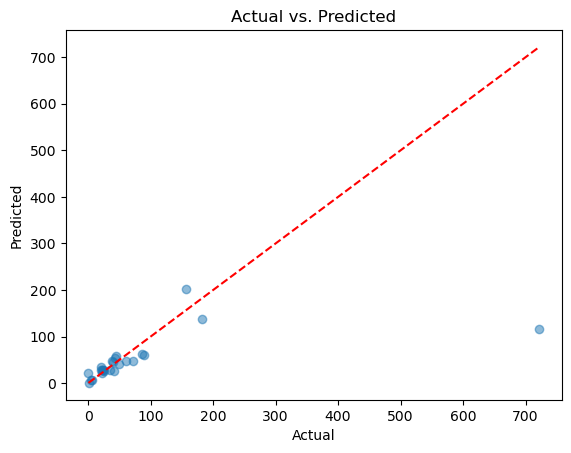

-------------------------------


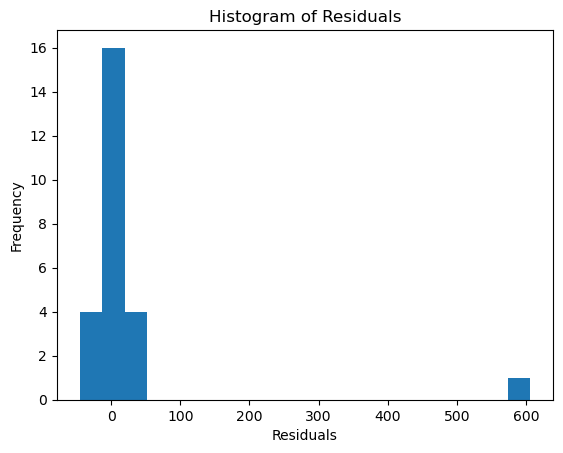

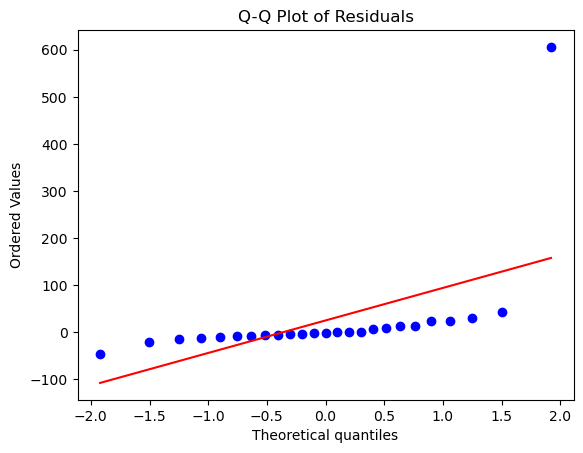

Permian
Number of data points:  308
Best k value: 1
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 543.8570641923923
MSE of the model: 711.8973806451611
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 26.68140514750228
MAE of the best KNN model: 11.124731182795697
-------------------------------
Quantile regression loss:
Quantile 0.25: 1.1300000000000001
Quantile 0.5: 5.49
Quantile 0.75: 12.0
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 11.83%
±10%: 26.88%
±15%: 27.96%
±20%: 35.48%
±50%: 54.84%
Performance range: 220.20
Minimum percentage difference: 0.00%
Maximum percentage difference: 2213.18%
-------------------------------
Cross-validation MSE scores: [ 175.14366744  230.23086512  152.9297186   276.48942558 3954.811

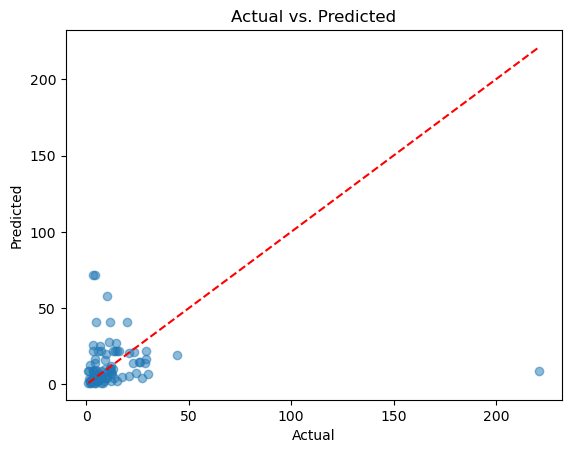

-------------------------------


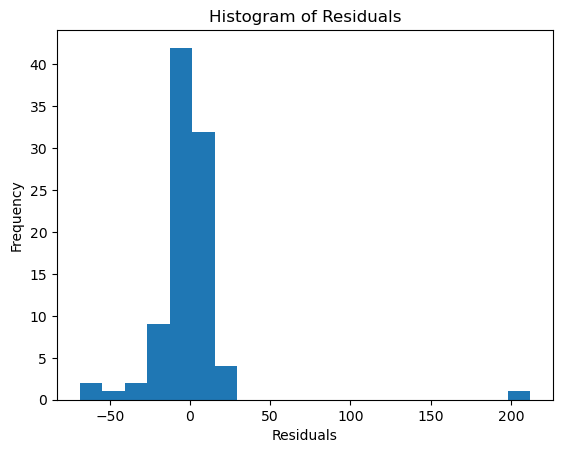

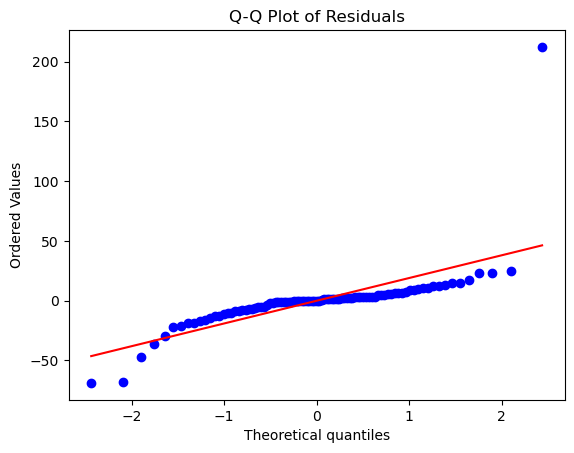

Oklahoma Platform
Number of data points:  167
Best k value: 3
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 207.0968208381392
MSE of the model: 135.1735692810458
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 11.626416871979337
MAE of the best KNN model: 9.021633986928107
-------------------------------
Quantile regression loss:
Quantile 0.25: 4.126666666666666
Quantile 0.5: 6.2
Quantile 0.75: 12.221666666666668
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 7.84%
±10%: 9.80%
±15%: 15.69%
±20%: 17.65%
±50%: 58.82%
Performance range: 67.00
Minimum percentage difference: 0.00%
Maximum percentage difference: 1423.29%
-------------------------------
Cross-validation MSE scores: [231.64165324 444.86956232 163.21914251 112.41978551 325.414

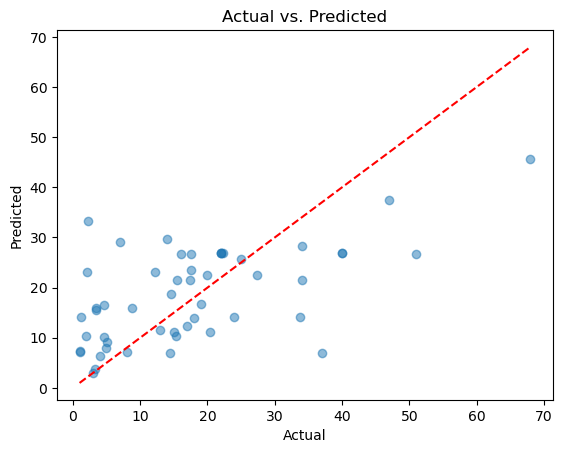

-------------------------------


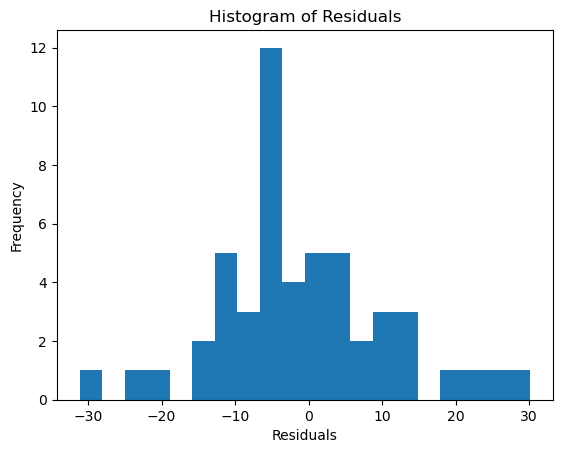

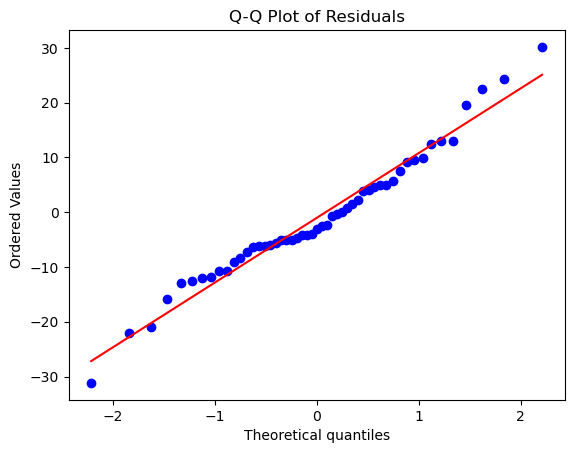

Gulf Coast
Number of data points:  273
Best k value: 17
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 11637.99750792683
MSE of the model: 16410.8003546544
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 128.1046461087747
MAE of the best KNN model: 92.99331420373026
-------------------------------
Quantile regression loss:
Quantile 0.25: 3.958823529411765
Quantile 0.5: 75.11764705882351
Quantile 0.75: 174.37485294117647
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 18.29%
±10%: 31.71%
±15%: 36.59%
±20%: 36.59%
±50%: 42.68%
Performance range: 439.00
Minimum percentage difference: 3.70%
Maximum percentage difference: 7473.31%
-------------------------------
Cross-validation MSE scores: [72042.62415677 15682.48962273 16192.

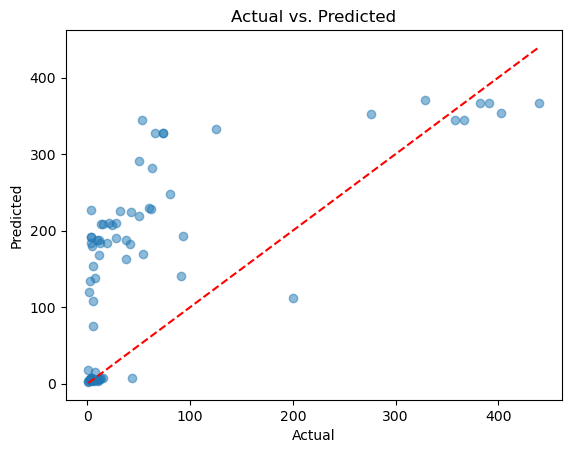

-------------------------------


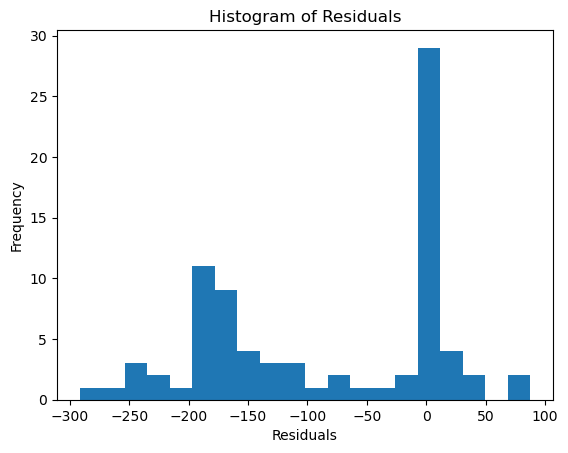

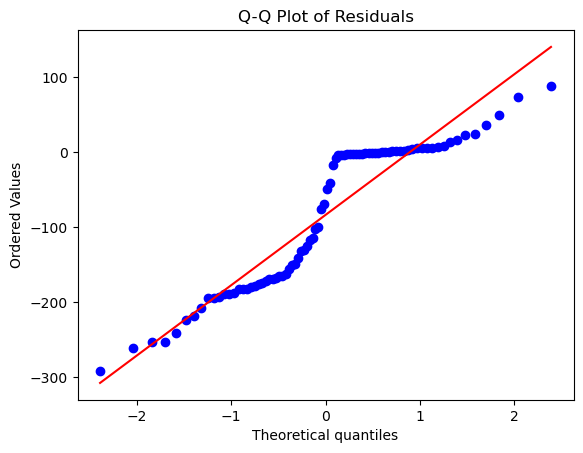

Williston
Number of data points:  375
Best k value: 8
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 3069.407528764979
MSE of the model: 3563.318348396018
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 59.693536906402336
MAE of the best KNN model: 31.148805309734513
-------------------------------
Quantile regression loss:
Quantile 0.25: 2.798749999999999
Quantile 0.5: 10.5
Quantile 0.75: 30.987500000000004
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 19.47%
±10%: 27.43%
±15%: 33.63%
±20%: 38.94%
±50%: 62.83%
Performance range: 343.00
Minimum percentage difference: 0.00%
Maximum percentage difference: 2405.00%
-------------------------------
Cross-validation MSE scores: [2012.74949177 1923.55055006 2571.86845334 4408.1

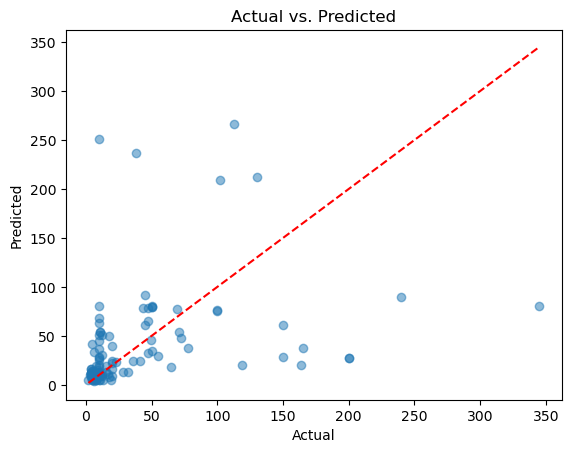

-------------------------------


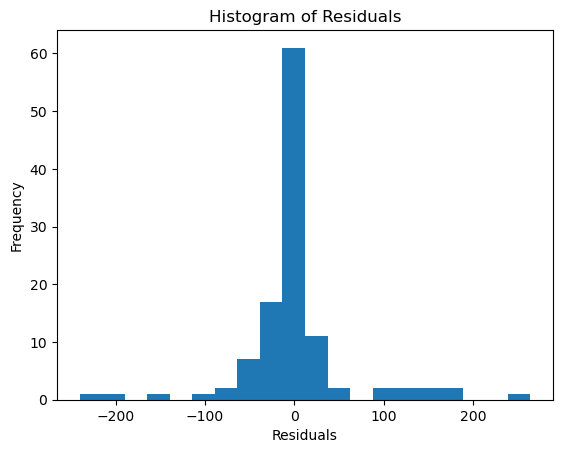

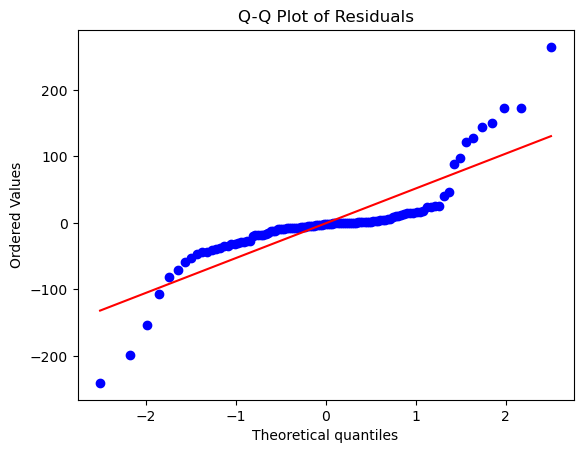

Michigan
Number of data points:  59
Best k value: 7
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 850.9316200617284
MSE of the model: 569.0388990929706
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 23.854536237222693
MAE of the best KNN model: 14.829206349206352
-------------------------------
Quantile regression loss:
Quantile 0.25: 3.489285714285713
Quantile 0.5: 9.664285714285715
Quantile 0.75: 14.157142857142858
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 11.11%
±10%: 22.22%
±15%: 33.33%
±20%: 38.89%
±50%: 77.78%
Performance range: 118.00
Minimum percentage difference: 0.45%
Maximum percentage difference: 1271.43%
-------------------------------
Cross-validation MSE scores: [ 70.65239955 243.12334796 410.33764592  25.55955459

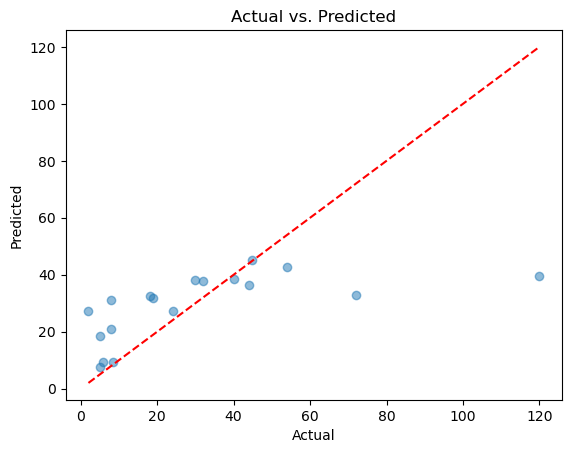

-------------------------------


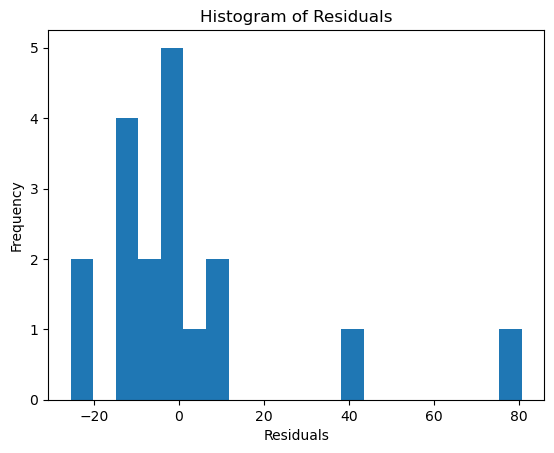

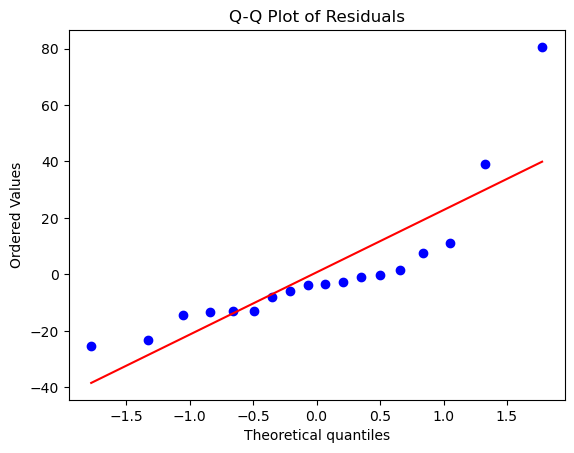

Pacific
Number of data points:  100
Best k value: 1
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 0.5223848888888888
MSE of the model: 0.37890333333333337
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 0.6155512434666454
MAE of the best KNN model: 0.3516666666666667
-------------------------------
Quantile regression loss:
Quantile 0.25: 0.04250000000000004
Quantile 0.5: 0.14499999999999985
Quantile 0.75: 0.4475000000000001
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 36.67%
±10%: 43.33%
±15%: 63.33%
±20%: 66.67%
±50%: 83.33%
Performance range: 2.82
Minimum percentage difference: 0.00%
Maximum percentage difference: 350.00%
-------------------------------
Cross-validation MSE scores: [ 0.46378571  0.42788929  0.39764286 15.66251429

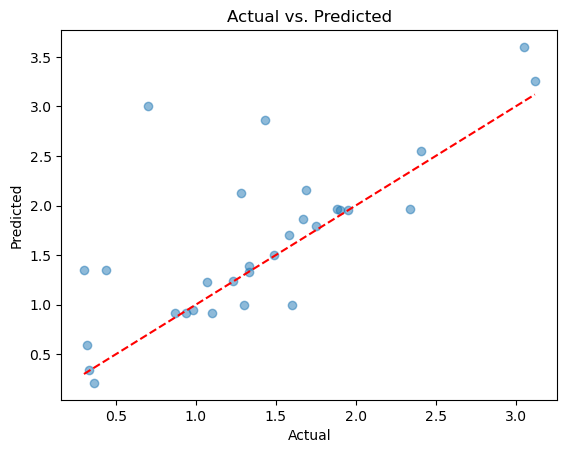

-------------------------------


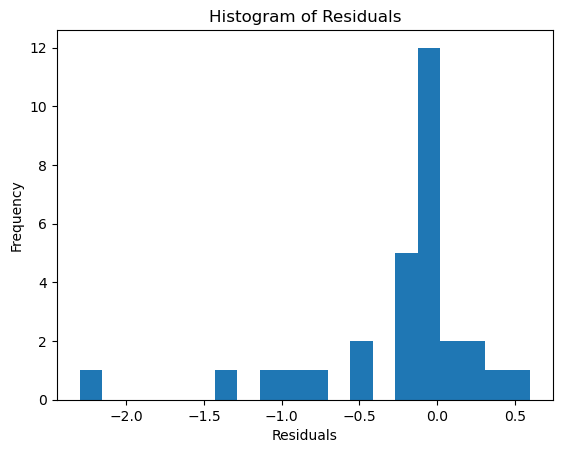

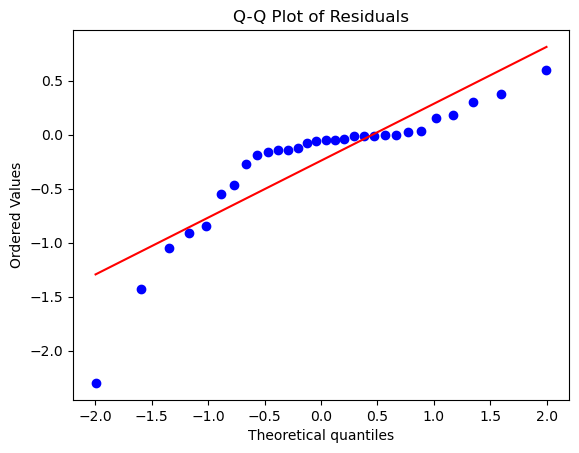

Illinois
Number of data points:  15
Best k value: 6
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 215.832704
MSE of the model: 265.7650027777778
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 16.302300536359212
MAE of the best KNN model: 12.715666666666667
-------------------------------
Quantile regression loss:
Quantile 0.25: 5.798333333333333
Quantile 0.5: 7.031666666666666
Quantile 0.75: 17.081666666666667
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 0.00%
±10%: 0.00%
±15%: 0.00%
±20%: 20.00%
±50%: 60.00%
Performance range: 39.88
Minimum percentage difference: 58.37%
Maximum percentage difference: 273.51%
-------------------------------
Cross-validation MSE scores: [ 47.579425   595.45916944 149.5765      25.15102

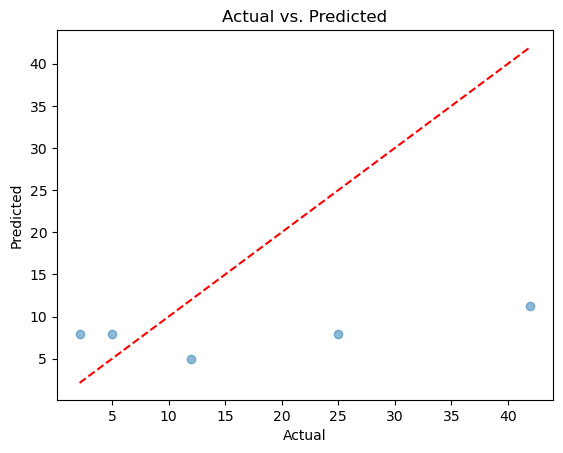

-------------------------------


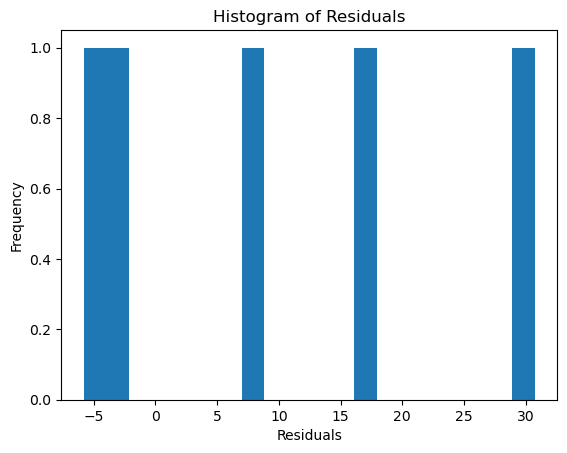

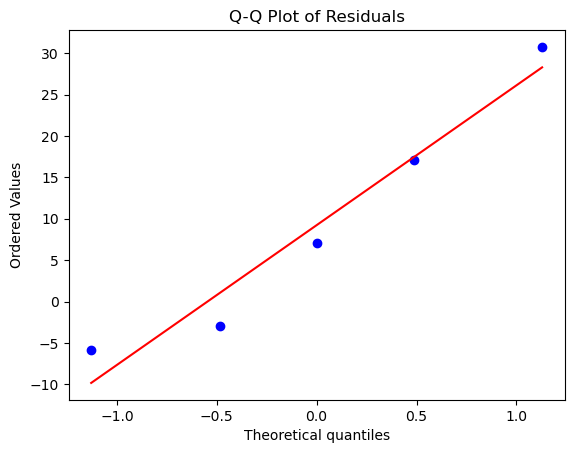

Great Plains
Number of data points:  37
Best k value: 1
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 4.93820763888889
MSE of the model: 8.862575000000001
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 2.9770077258885306
MAE of the best KNN model: 2.3608333333333333
-------------------------------
Quantile regression loss:
Quantile 0.25: 1.0225
Quantile 0.5: 2.0
Quantile 0.75: 3.0
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 8.33%
±10%: 8.33%
±15%: 8.33%
±20%: 33.33%
±50%: 83.33%
Performance range: 6.30
Minimum percentage difference: 0.00%
Maximum percentage difference: 78.49%
-------------------------------
Cross-validation MSE scores: [3.81568000e+00 1.04877816e+05 6.21170000e+00 2.32156800e+01
 3.02304800e+01]
Mean

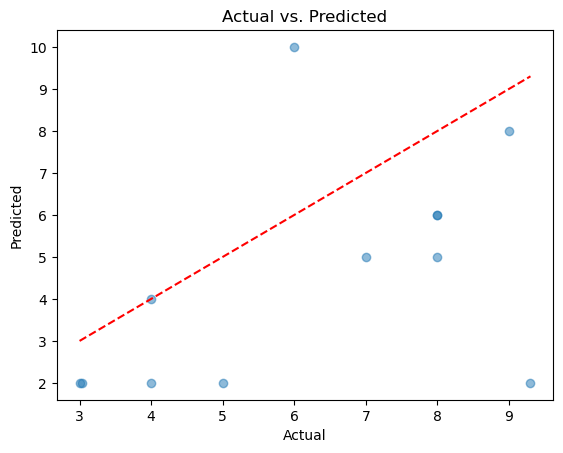

-------------------------------


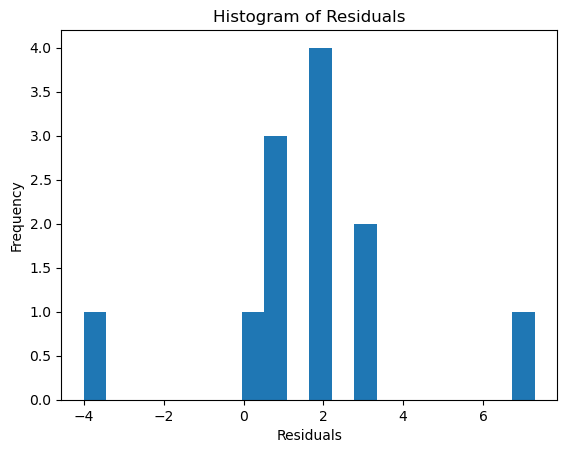

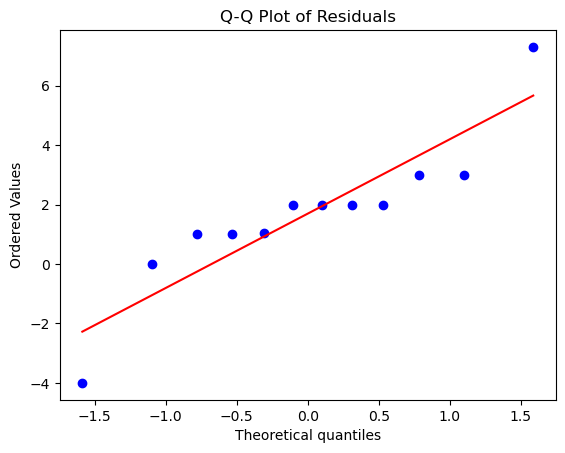

Anadarko
Number of data points:  232
Best k value: 5
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 5763.469534204081
MSE of the model: 4325.166099485714
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 65.76599500871035
MAE of the best KNN model: 19.16071428571428
-------------------------------
Quantile regression loss:
Quantile 0.25: 0.2654999999999995
Quantile 0.5: 0.976
Quantile 0.75: 6.484999999999999
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 54.29%
±10%: 64.29%
±15%: 67.14%
±20%: 70.00%
±50%: 85.71%
Performance range: 479.00
Minimum percentage difference: 0.00%
Maximum percentage difference: 2949.60%
-------------------------------
Cross-validation MSE scores: [  544.4784223   2171.11801903  3202.88359437  7428.51691925
 137

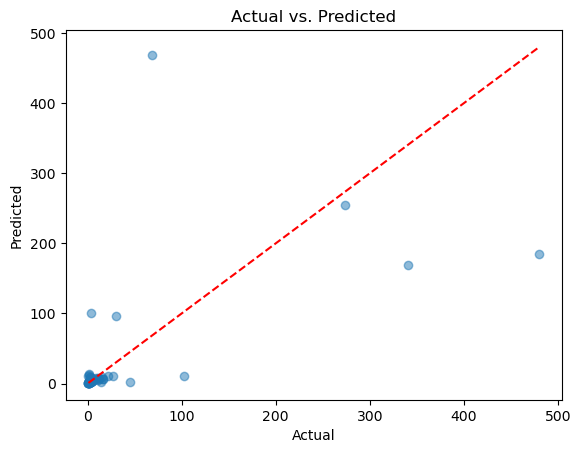

-------------------------------


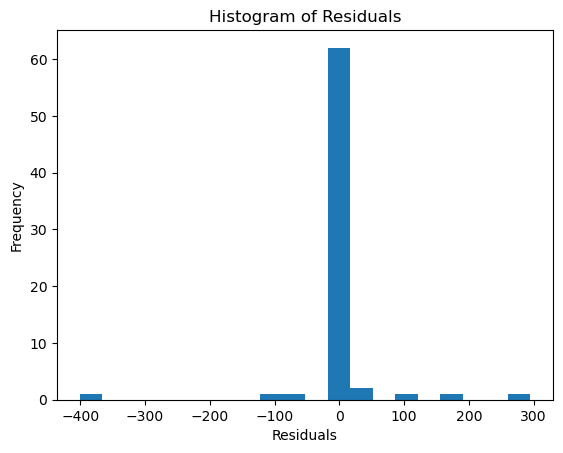

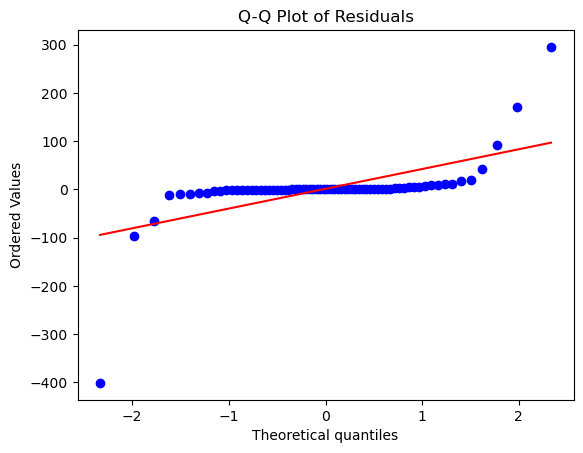

Rocky Mountain
Number of data points:  621
Best k value: 13
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 159.26972425290978
MSE of the model: 147.12020979337402
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 12.129312008245728
MAE of the best KNN model: 6.7117359111476755
-------------------------------
Quantile regression loss:
Quantile 0.25: 2.0769230769230766
Quantile 0.5: 3.3876923076923067
Quantile 0.75: 6.515384615384616
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 4.81%
±10%: 9.09%
±15%: 15.51%
±20%: 21.39%
±50%: 59.36%
Performance range: 104.00
Minimum percentage difference: 0.00%
Maximum percentage difference: 1115.38%
-------------------------------
Cross-validation MSE scores: [115.67785315  46.16337091  90.10050603 258

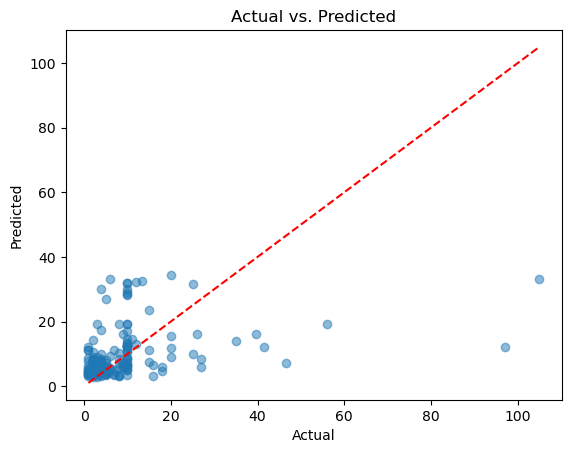

-------------------------------


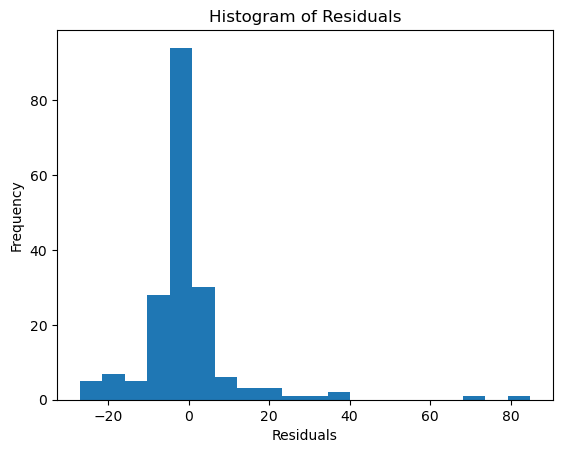

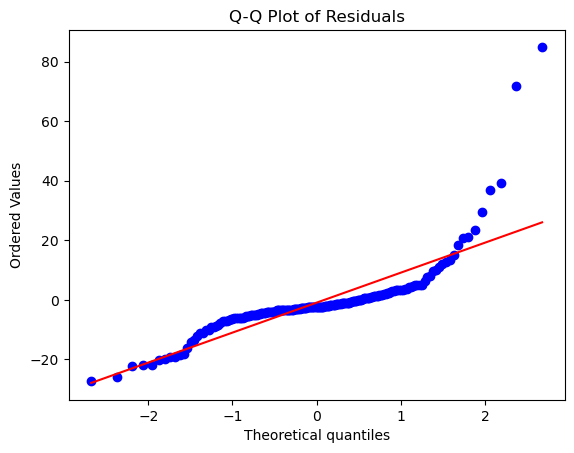

Fort Worth
Number of data points:  9
Best k value: 1
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 140.2254222222222
MSE of the model: 7.6848
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 2.7721471822397885
MAE of the best KNN model: 2.6266666666666665
-------------------------------
Quantile regression loss:
Quantile 0.25: 2.0
Quantile 0.5: 2.0
Quantile 0.75: 2.94
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 0.00%
±10%: 0.00%
±15%: 66.67%
±20%: 66.67%
±50%: 100.00%
Performance range: 26.88
Minimum percentage difference: 6.90%
Maximum percentage difference: 183.02%
-------------------------------
Cross-validation MSE scores: [1875.76805    9.        16.         9.       615.5361 ]
Mean cross-validation MSE: 505.06083
-------------

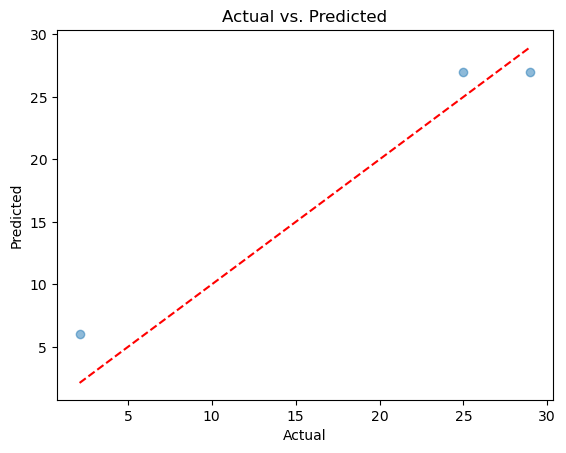

-------------------------------


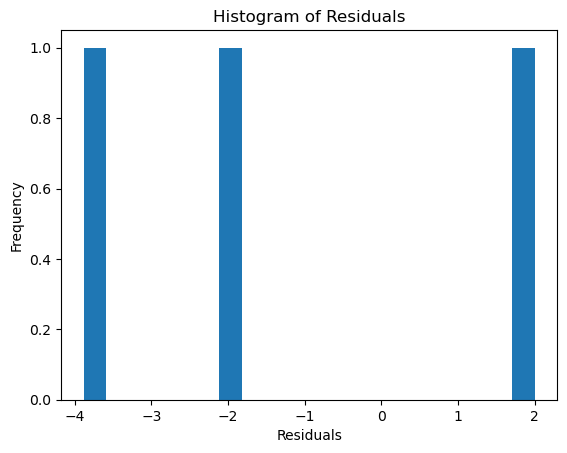

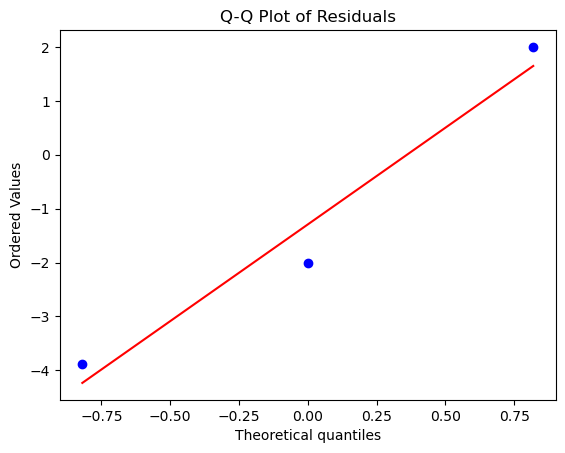

,round,basin,data_row_count,feature_quantity,feature_list,target_variable_variance,mse,rmse,mae,0.25_quantile_loss,0.5_quantile_loss,0.75_quantile_loss,%_of_results_within_5%,%_of_results_within_10%,%_of_results_within_15%,%_of_results_within_20%,%_of_results_within_50%,results_min%_difference,results_max%_difference,cross_val_mse
11,01,Fort Worth,9,27,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",140.23,7.68,2.77,2.63,2.00,2.00,2.94,0.00,66.67,66.67,66.67,66.67,6.90,183.02,505.06
6,01,Pacific,100,43,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",0.52,0.38,0.62,0.35,0.04,0.14,0.45,40.00,50.00,56.67,66.67,80.00,0.00,350.00,3.46
9,01,Anadarko,232,81,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",5763.47,4325.17,65.77,19.16,0.27,0.98,6.48,17.14,28.57,41.43,47.14,65.71,0.00,2949.60,5417.15
5,01,Michigan,59,48,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",850.93,569.04,23.85,14.83,3.49,9.66,14.16,11.11,11.11,22.22,33.33,44.44,0.45,1271.43,182.02
4,01,Williston,375,77,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",3069.41,3563.32,59.69,31.15,2.80,10.50,30.99,7.08,13.27,19.47,22.12,40.71,0.00,2405.00,3533.83
1,01,Permian,308,118,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",543.86,711.90,26.68,11.12,1.13,5.49,12.00,10.75,13.98,17.20,18.28,48.39,0.00,2213.18,957.92
8,01,Great Plains,37,59,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",4.94,8.86,2.98,2.36,1.02,2.00,3.00,8.33,8.33,16.67,16.67,75.00,0.00,78.49,20988.26
0,01,Appalachian,81,65,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",19404.58,14993.14,122.45,36.54,4.50,8.65,20.60,8.00,12.00,16.00,32.00,80.00,2.27,4120.00,1829.26
2,01,Oklahoma Platform,167,104,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",207.10,135.17,11.63,9.02,4.13,6.20,12.22,3.92,5.88,13.73,17.65,56.86,0.00,1423.29,255.51
3,01,Gulf Coast,273,127,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",11638.00,16410.80,128.10,92.99,3.96,75.12,174.37,2.44,6.10,12.20,17.07,28.05,3.70,7473.31,34322.46


In [101]:
# Define all the variables...
df = df_data.copy()
round = '01'
basins = df_data['BASIN_CATEGORY'].unique()
columns_to_drop = ['IDUSGS', 'PERIOD', 'DATESAMPLE', 'API', 'Ba', 'Zn', 'B', 'FeTot', 'DEPTHLOWER', 'Sr', 'Br', 'HCO3', 'WELLTYPE', 'STATE', 'WELLNAME']
categorical_columns = ['PLAYTYPE', 'FORMSIMPLE', 'COUNTY', 'PROVINCE', 'REGION']
test_size = 0.3
random_state = 42
k_values = list(range(1, 21))

# # Run the function...
# generate_knn_models_by_basin(df=df, round=round, basins=basins, columns_to_drop=columns_to_drop, categorical_columns=categorical_columns, test_size=test_size, random_state=random_state, k_values=k_values)

# Run the function...
df_round01 = generate_knn_models_by_basin(df=df, round=round, basins=basins, columns_to_drop=columns_to_drop, categorical_columns=categorical_columns, 
                                          test_size=test_size, random_state=random_state, k_values=k_values)
df_round01

### ROUND 2

Appalachian
Number of data points:  81
Best k value: 1
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 19404.581984
MSE of the model: 20862.445200000002
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 144.4383785563934
MAE of the best KNN model: 46.604
-------------------------------
Quantile regression loss:
Quantile 0.25: 2.9
Quantile 0.5: 9.100000000000001
Quantile 0.75: 19.599999999999998
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 40.00%
±10%: 48.00%
±15%: 56.00%
±20%: 60.00%
±50%: 84.00%
Performance range: 721.50
Minimum percentage difference: 1.64%
Maximum percentage difference: 111.11%
-------------------------------
Cross-validation MSE scores: [ 439.815      3536.38727273 2537.06181818 1275.92454545  726.96181

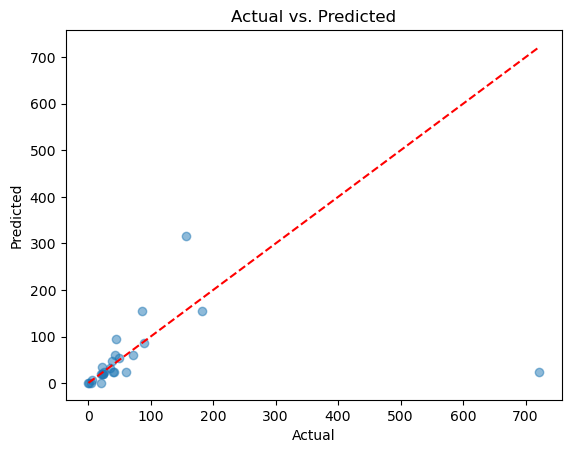

-------------------------------


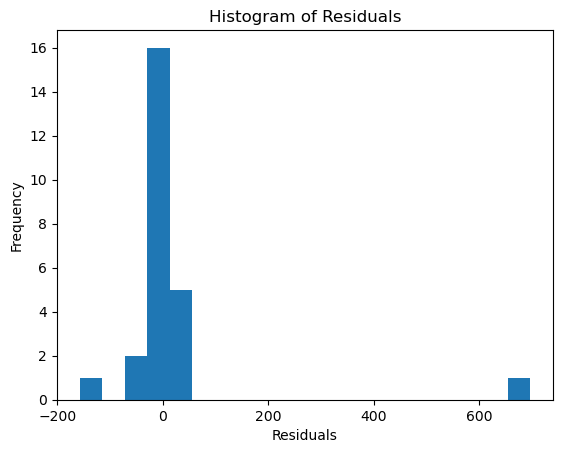

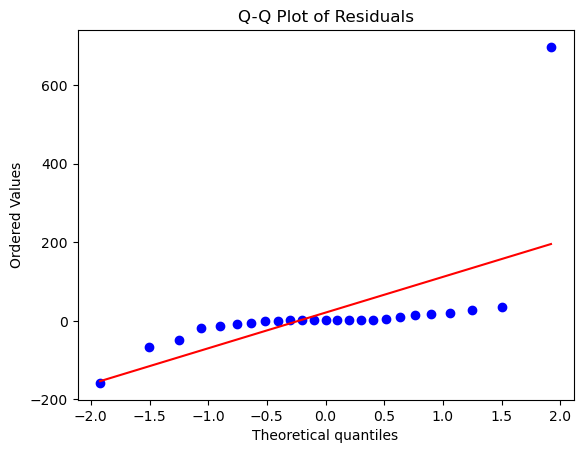

Permian
Number of data points:  308
Best k value: 13
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 543.8570641923923
MSE of the model: 550.222334135013
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 23.4568184998523
MAE of the best KNN model: 8.25617866004963
-------------------------------
Quantile regression loss:
Quantile 0.25: 1.5969230769230762
Quantile 0.5: 4.22076923076923
Quantile 0.75: 8.96
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 8.60%
±10%: 16.13%
±15%: 27.96%
±20%: 35.48%
±50%: 60.22%
Performance range: 220.20
Minimum percentage difference: 1.12%
Maximum percentage difference: 1489.76%
-------------------------------
Cross-validation MSE scores: [ 132.32344249   69.23457098   57.41961526  159.40444394 

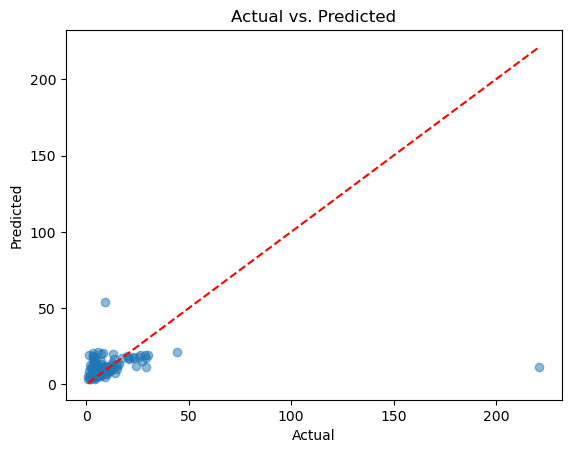

-------------------------------


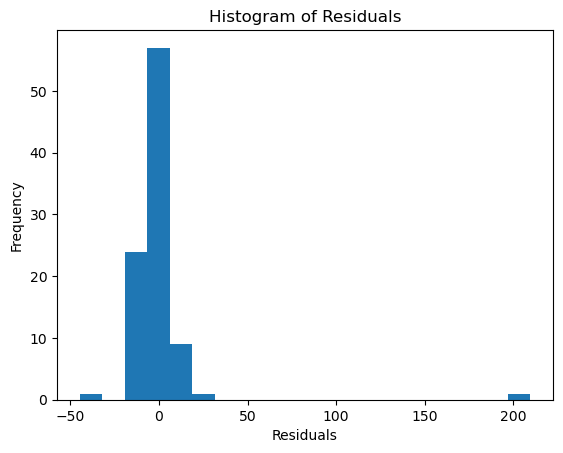

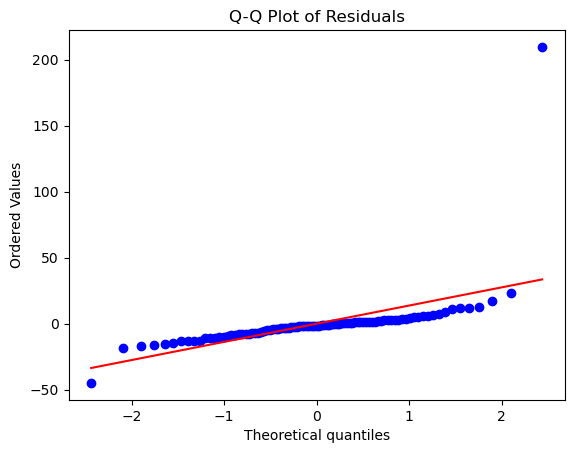

Oklahoma Platform
Number of data points:  167
Best k value: 3
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 207.0968208381392
MSE of the model: 202.90811154684096
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 14.244581831238182
MAE of the best KNN model: 10.068627450980392
-------------------------------
Quantile regression loss:
Quantile 0.25: 3.035
Quantile 0.5: 6.713333333333331
Quantile 0.75: 14.341666666666667
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 3.92%
±10%: 7.84%
±15%: 17.65%
±20%: 37.25%
±50%: 60.78%
Performance range: 67.00
Minimum percentage difference: 0.00%
Maximum percentage difference: 1257.34%
-------------------------------
Cross-validation MSE scores: [117.57626019 339.57065507 294.22047585 121.11500918 268

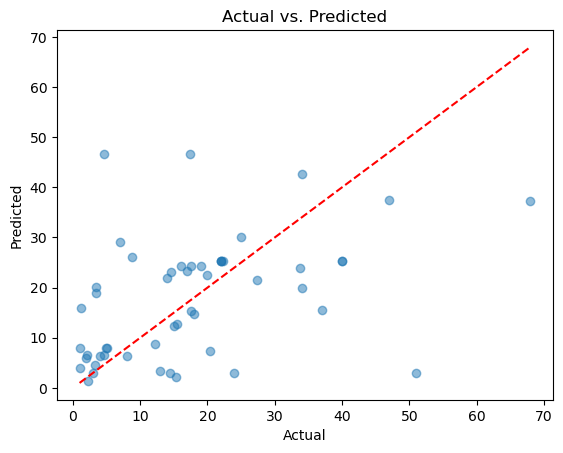

-------------------------------


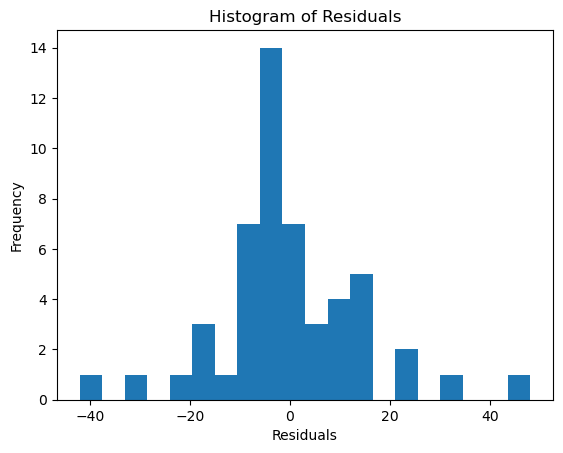

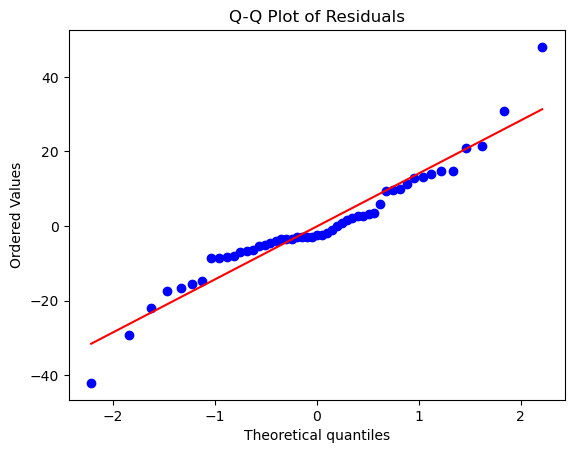

Gulf Coast
Number of data points:  284
Best k value: 18
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 7480.405759329367
MSE of the model: 9006.74089411427
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 94.90385078654222
MAE of the best KNN model: 53.187674418604644
-------------------------------
Quantile regression loss:
Quantile 0.25: 2.055833333333333
Quantile 0.5: 8.421666666666667
Quantile 0.75: 81.13055555555556
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 31.40%
±10%: 43.02%
±15%: 47.67%
±20%: 51.16%
±50%: 63.95%
Performance range: 342.61
Minimum percentage difference: 1.06%
Maximum percentage difference: 4820.80%
-------------------------------
Cross-validation MSE scores: [ 4168.49374152  6299.03725306 58111.

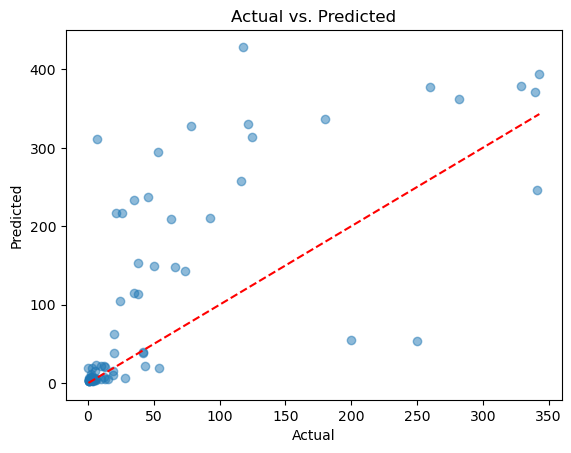

-------------------------------


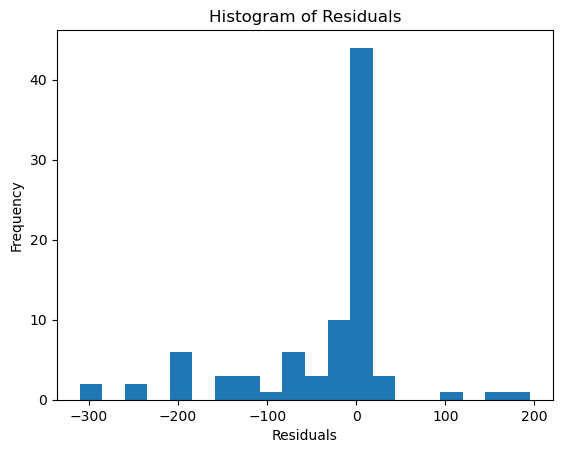

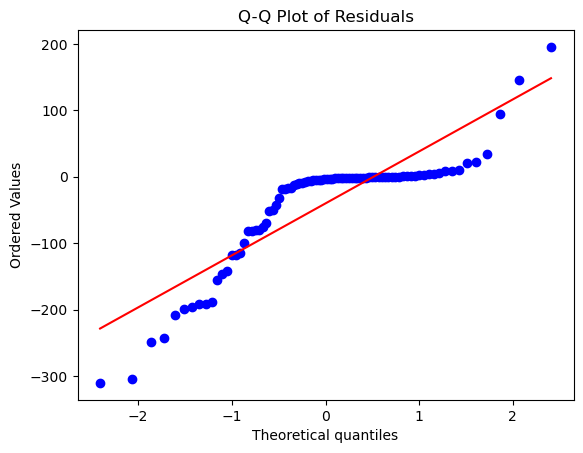

Williston
Number of data points:  398
Best k value: 7
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 5056.48078065972
MSE of the model: 4534.183174472789
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 67.33634363753937
MAE of the best KNN model: 33.603988095238094
-------------------------------
Quantile regression loss:
Quantile 0.25: 3.1892857142857265
Quantile 0.5: 13.428571428571427
Quantile 0.75: 34.723928571428566
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 15.83%
±10%: 29.17%
±15%: 37.50%
±20%: 42.50%
±50%: 59.17%
Performance range: 473.00
Minimum percentage difference: 0.00%
Maximum percentage difference: 3396.43%
-------------------------------
Cross-validation MSE scores: [2559.0043644  1372.39081618 3737.64490641 2792.53

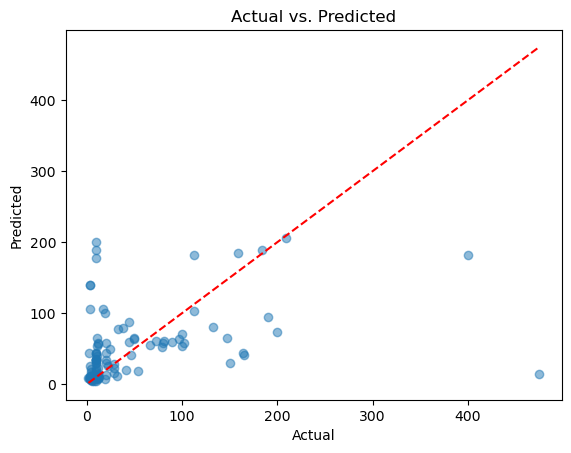

-------------------------------


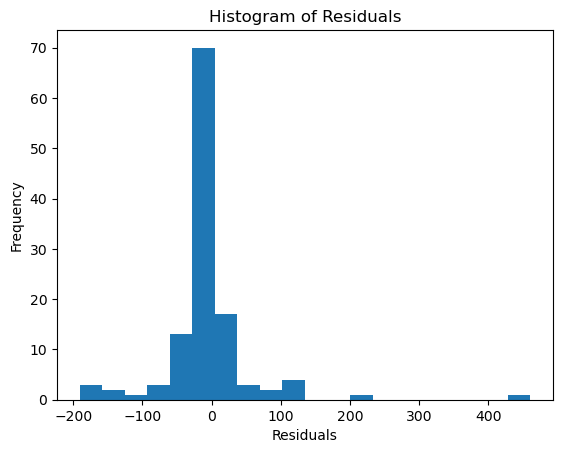

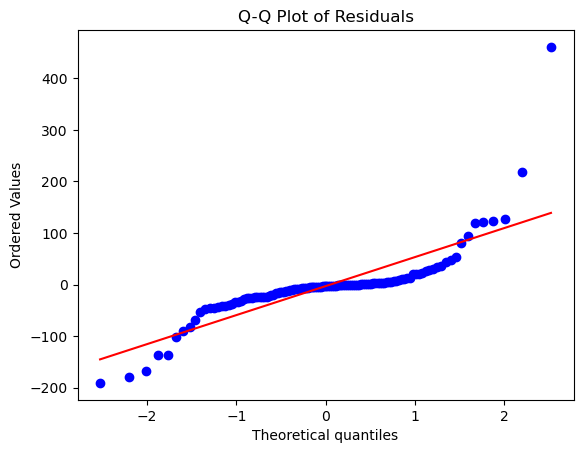

Michigan
Number of data points:  59
Best k value: 2
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 850.9316200617284
MSE of the model: 620.6669638888889
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 24.91318855323198
MAE of the best KNN model: 15.062222222222223
-------------------------------
Quantile regression loss:
Quantile 0.25: 1.5512499999999996
Quantile 0.5: 8.5
Quantile 0.75: 21.375
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 27.78%
±10%: 33.33%
±15%: 38.89%
±20%: 44.44%
±50%: 61.11%
Performance range: 118.00
Minimum percentage difference: 1.14%
Maximum percentage difference: 650.00%
-------------------------------
Cross-validation MSE scores: [ 93.68944444  98.92882812 424.64039063  13.699225   211.9544875 ]
Mean cross-v

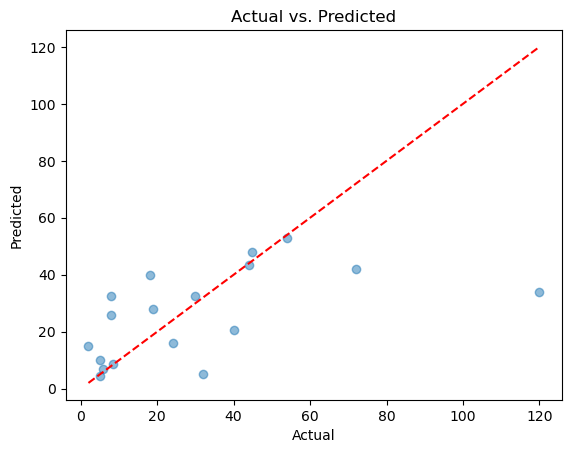

-------------------------------


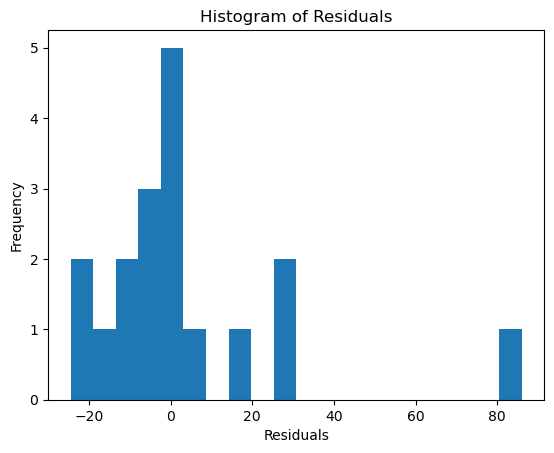

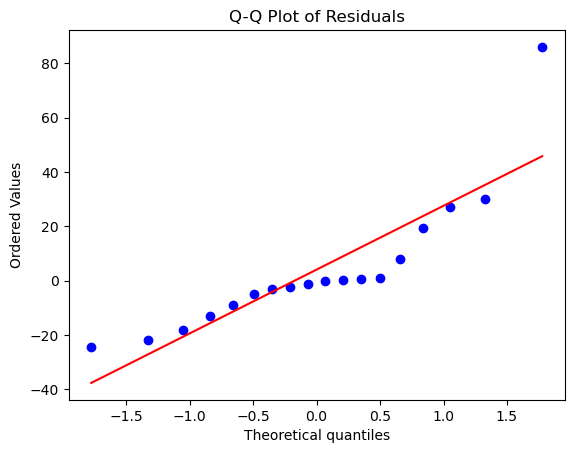

Pacific
Number of data points:  100
Best k value: 3
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 0.5223848888888888
MSE of the model: 0.20104999999999995
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 0.44838599442890714
MAE of the best KNN model: 0.2667777777777778
-------------------------------
Quantile regression loss:
Quantile 0.25: 0.07208333333333335
Quantile 0.5: 0.15666666666666662
Quantile 0.75: 0.2866666666666664
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 23.33%
±10%: 46.67%
±15%: 60.00%
±20%: 73.33%
±50%: 93.33%
Performance range: 2.82
Minimum percentage difference: 0.14%
Maximum percentage difference: 134.36%
-------------------------------
Cross-validation MSE scores: [ 0.63212302  0.26994722  0.47356508 15.4799492

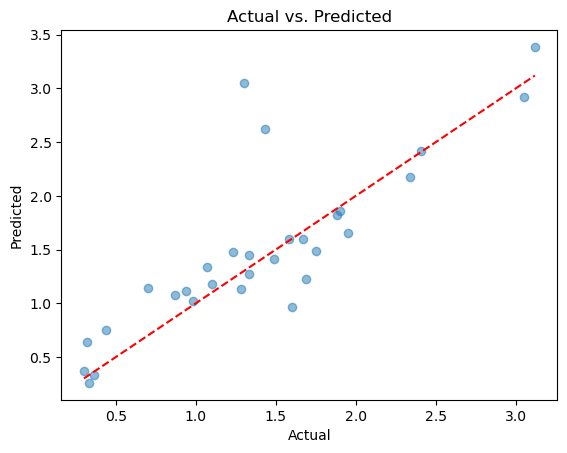

-------------------------------


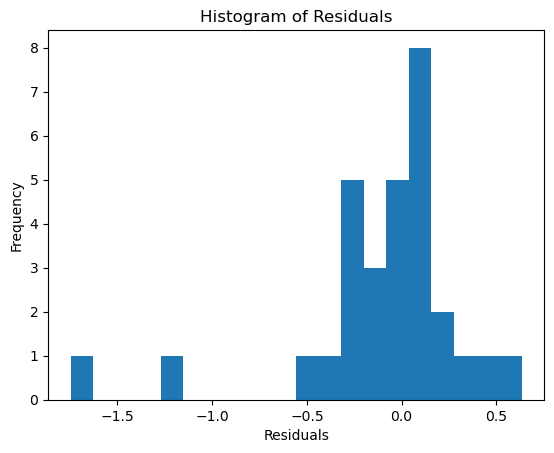

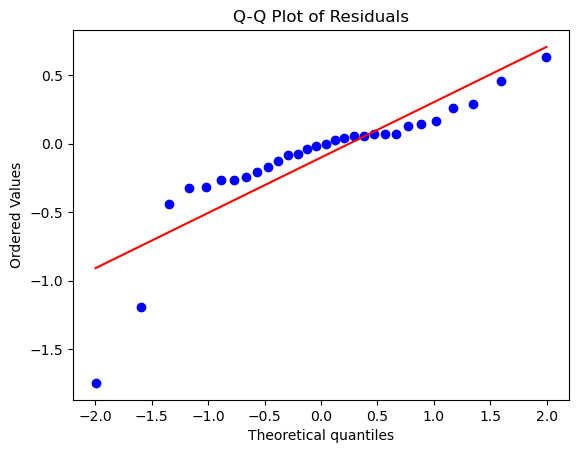

Illinois
Number of data points:  15
Best k value: 6
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 215.832704
MSE of the model: 262.3683422222222
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 16.197788189201088
MAE of the best KNN model: 12.268666666666666
-------------------------------
Quantile regression loss:
Quantile 0.25: 4.081666666666667
Quantile 0.5: 5.971666666666667
Quantile 0.75: 17.45
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 0.00%
±10%: 0.00%
±15%: 0.00%
±20%: 20.00%
±50%: 60.00%
Performance range: 39.88
Minimum percentage difference: 34.01%
Maximum percentage difference: 281.68%
-------------------------------
Cross-validation MSE scores: [ 47.579425   605.57253611 149.5765      25.15102778  15.23990

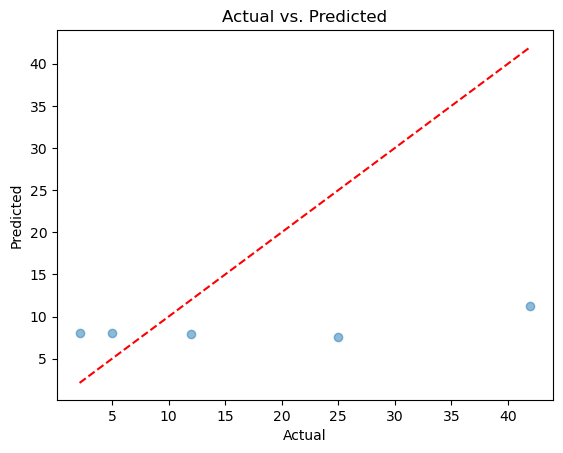

-------------------------------


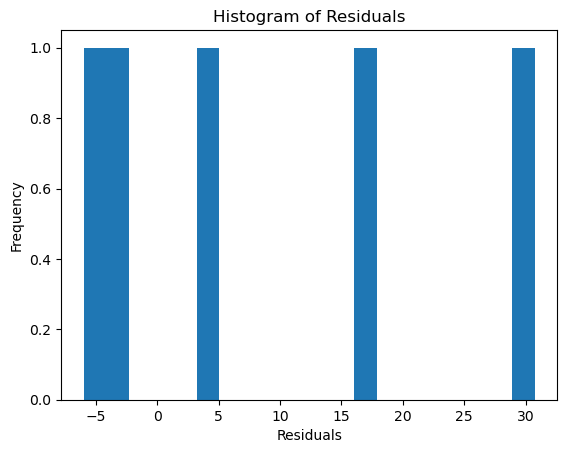

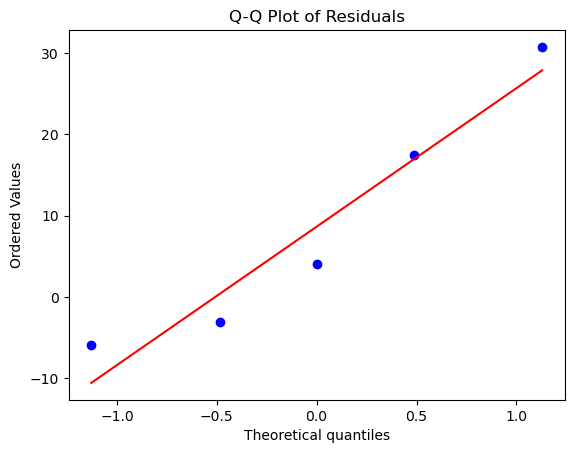

Great Plains
Number of data points:  37
Best k value: 7
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 4.93820763888889
MSE of the model: 8.958652551020409
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 2.993100825401712
MAE of the best KNN model: 2.2132142857142854
-------------------------------
Quantile regression loss:
Quantile 0.25: 0.6275000000000001
Quantile 0.5: 1.3750000000000002
Quantile 0.75: 3.3925
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 16.67%
±10%: 25.00%
±15%: 33.33%
±20%: 41.67%
±50%: 75.00%
Performance range: 6.30
Minimum percentage difference: 3.61%
Maximum percentage difference: 67.84%
-------------------------------
Cross-validation MSE scores: [5.71723837e+00 1.04339178e+05 1.07778665e+01 2.15

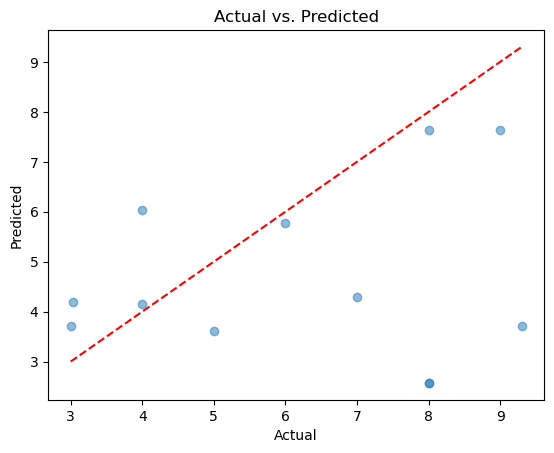

-------------------------------


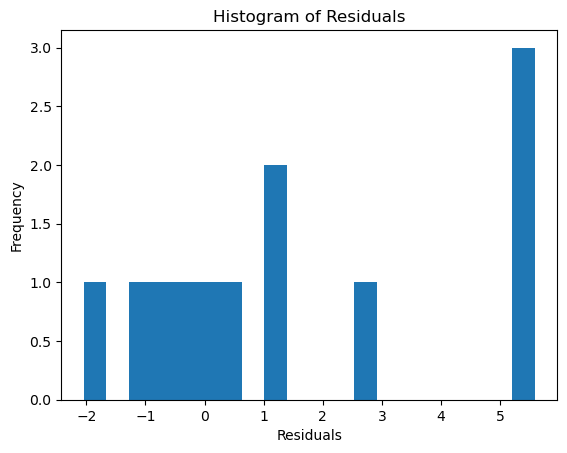

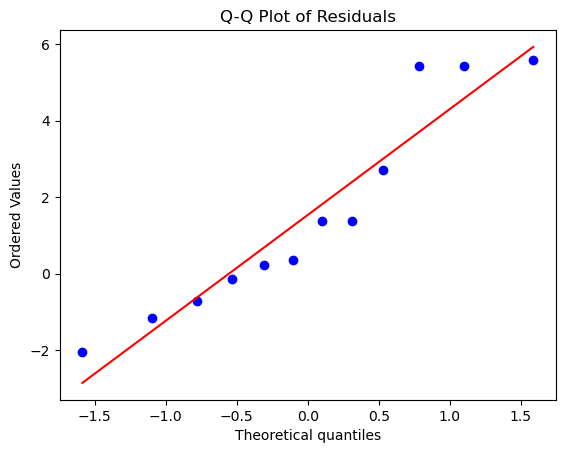

Anadarko
Number of data points:  232
Best k value: 5
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 5763.469534204081
MSE of the model: 2555.6606581142855
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 50.55354248827955
MAE of the best KNN model: 15.331971428571427
-------------------------------
Quantile regression loss:
Quantile 0.25: 0.40849999999999975
Quantile 0.5: 0.946
Quantile 0.75: 6.697000000000001
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 51.43%
±10%: 62.86%
±15%: 70.00%
±20%: 71.43%
±50%: 85.71%
Performance range: 479.00
Minimum percentage difference: 0.00%
Maximum percentage difference: 2422.74%
-------------------------------
Cross-validation MSE scores: [  799.18194764  2919.86000618  4963.71336037  6260.94510225
 

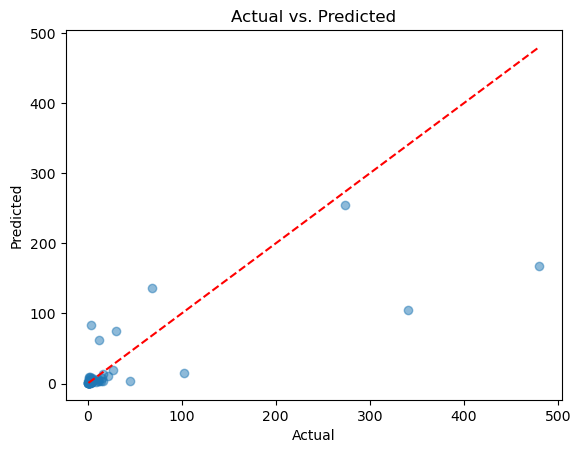

-------------------------------


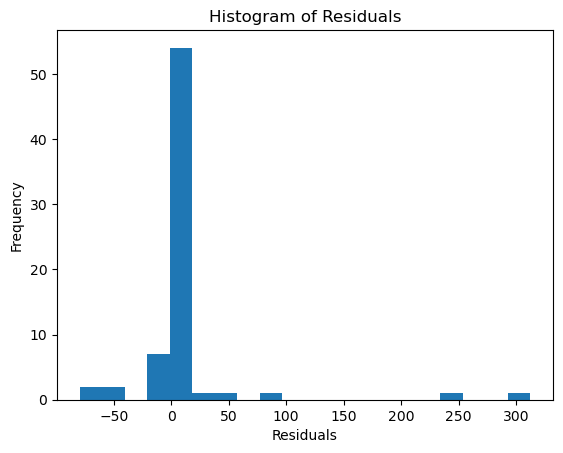

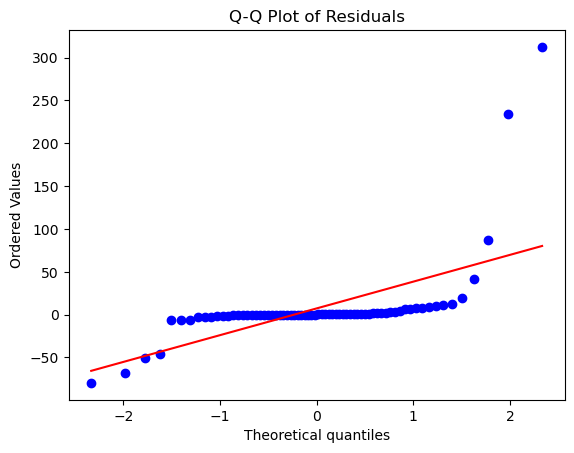

Rocky Mountain
Number of data points:  621
Best k value: 18
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 159.26972425290978
MSE of the model: 147.30167650524857
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 12.136790206032588
MAE of the best KNN model: 6.505522875816994
-------------------------------
Quantile regression loss:
Quantile 0.25: 1.4994444444444444
Quantile 0.5: 3.277222222222223
Quantile 0.75: 6.386666666666667
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 7.49%
±10%: 14.44%
±15%: 20.86%
±20%: 30.48%
±50%: 62.03%
Performance range: 104.00
Minimum percentage difference: 0.00%
Maximum percentage difference: 917.72%
-------------------------------
Cross-validation MSE scores: [116.84263798  42.36023395  94.24183895 258.3

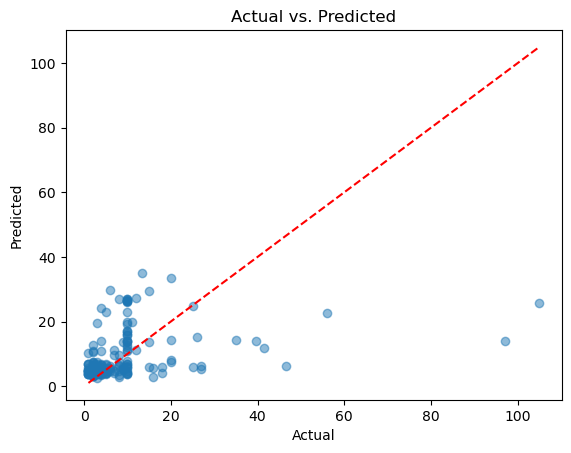

-------------------------------


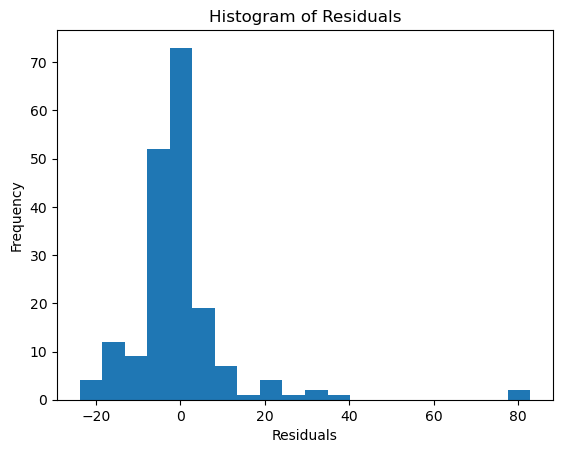

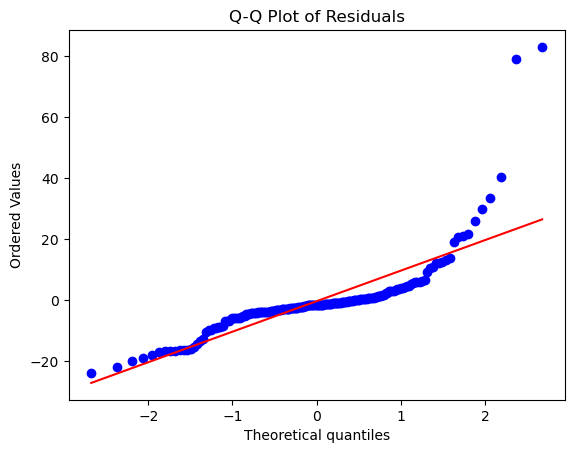

Fort Worth
Number of data points:  9
Best k value: 1
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 140.2254222222222
MSE of the model: 126.6848
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 11.255434243066768
MAE of the best KNN model: 8.293333333333333
-------------------------------
Quantile regression loss:
Quantile 0.25: 2.94
Quantile 0.5: 3.88
Quantile 0.75: 11.44
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 0.00%
±10%: 0.00%
±15%: 33.33%
±20%: 33.33%
±50%: 66.67%
Performance range: 26.88
Minimum percentage difference: 8.00%
Maximum percentage difference: 183.02%
-------------------------------
Cross-validation MSE scores: [1875.76805    9.        16.         9.       615.5361 ]
Mean cross-validation MSE: 505.06083
----------

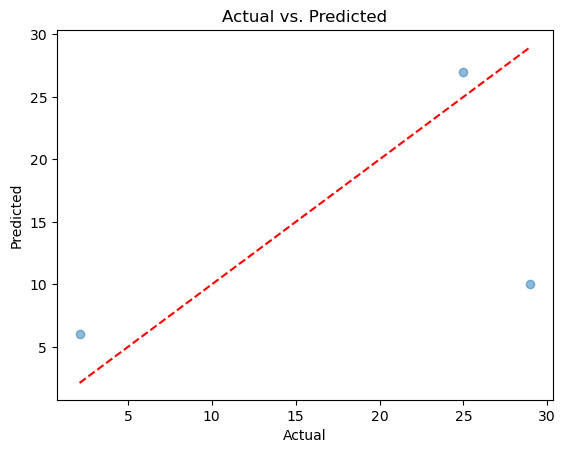

-------------------------------


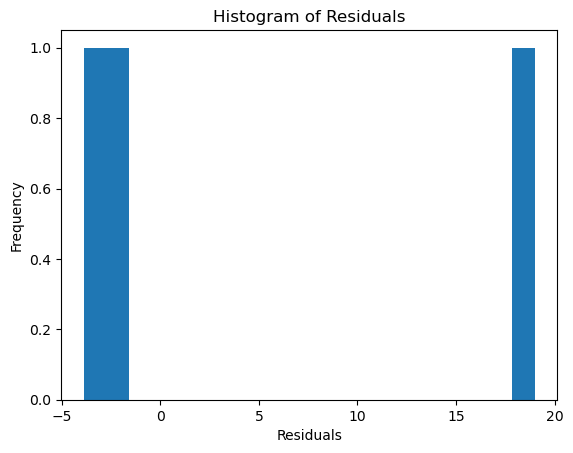

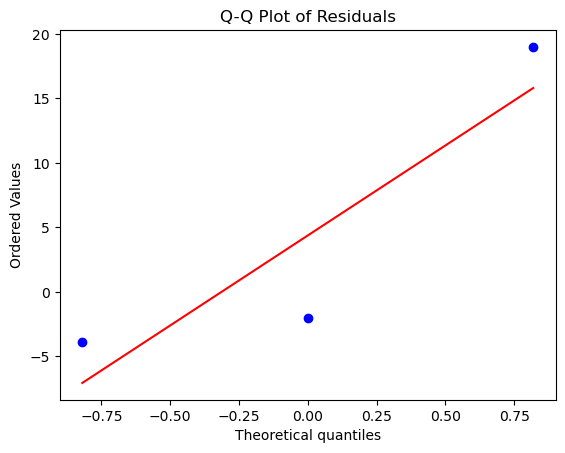

,round,basin,data_row_count,feature_quantity,feature_list,target_variable_variance,mse,rmse,mae,0.25_quantile_loss,0.5_quantile_loss,0.75_quantile_loss,%_of_results_within_5%,%_of_results_within_10%,%_of_results_within_15%,%_of_results_within_20%,%_of_results_within_50%,results_min%_difference,results_max%_difference,cross_val_mse
6,02,Pacific,100,12,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",0.52,0.20,0.45,0.27,0.07,0.16,0.29,30.00,46.67,53.33,63.33,83.33,0.14,134.36,3.44
0,02,Appalachian,81,12,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",19404.58,20862.45,144.44,46.60,2.90,9.10,19.60,16.00,28.00,40.00,44.00,64.00,1.64,111.11,1703.23
5,02,Michigan,59,12,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",850.93,620.67,24.91,15.06,1.55,8.50,21.38,16.67,33.33,33.33,33.33,61.11,1.14,650.00,168.58
11,02,Fort Worth,9,12,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",140.23,126.68,11.26,8.29,2.94,3.88,11.44,0.00,33.33,33.33,33.33,33.33,8.00,183.02,505.06
9,02,Anadarko,232,12,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",5763.47,2555.66,50.55,15.33,0.41,0.95,6.70,11.43,18.57,30.00,40.00,65.71,0.00,2422.74,6533.25
8,02,Great Plains,37,12,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",4.94,8.96,2.99,2.21,0.63,1.38,3.39,25.00,25.00,25.00,33.33,66.67,3.61,67.84,20877.95
1,02,Permian,308,12,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",543.86,550.22,23.46,8.26,1.60,4.22,8.96,5.38,11.83,20.43,27.96,54.84,1.12,1489.76,927.51
4,02,Williston,398,12,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",5056.48,4534.18,67.34,33.60,3.19,13.43,34.72,9.17,12.50,16.67,20.00,45.83,0.00,3396.43,2927.50
3,02,Gulf Coast,284,12,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",7480.41,9006.74,94.90,53.19,2.06,8.42,81.13,5.81,10.47,12.79,17.44,34.88,1.06,4820.80,24705.64
10,02,Rocky Mountain,621,12,"[TDS, LATITUDE, LONGITUDE, DEPTHUPPER, PH, Ca,...",159.27,147.30,12.14,6.51,1.50,3.28,6.39,2.67,10.16,12.30,16.04,37.97,0.00,917.72,145.93


In [106]:
# Define all the variables...
df = df_data.copy()
round = '02'
basins = df_data['BASIN_CATEGORY'].unique()
columns_to_drop = ['IDUSGS', 'PERIOD', 'DATESAMPLE', 'API', 'Ba', 'Zn', 'B', 'FeTot', 'DEPTHLOWER', 'Sr', 'Br', 'HCO3', 'WELLTYPE', 'STATE', 'WELLNAME', 'PLAYTYPE', 'FORMSIMPLE', 'COUNTY', 'PROVINCE', 'REGION']
categorical_columns = [] # NONE for this round
test_size = 0.3
random_state = 42
k_values = list(range(1, 21))

# Run the function...
df_round02 = generate_knn_models_by_basin(df=df, round=round, basins=basins, columns_to_drop=columns_to_drop, categorical_columns=categorical_columns,
                                          test_size=test_size, random_state=random_state, k_values=k_values)
df_round02

### ROUND 3

Appalachian
Number of data points:  0
No round03 model generated for Appalachian.
Permian
Number of data points:  0
No round03 model generated for Permian.
Oklahoma Platform
Number of data points:  0
No round03 model generated for Oklahoma Platform.
Gulf Coast
Number of data points:  105


Best k value: 1
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 20133.5612359375
MSE of the model: 3773.1033812499995
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 61.4255922336122
MAE of the best KNN model: 30.17875
-------------------------------
Quantile regression loss:
Quantile 0.25: 0.45000000000000007
Quantile 0.5: 2.655
Quantile 0.75: 42.25
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 59.38%
±10%: 62.50%
±15%: 65.62%
±20%: 65.62%
±50%: 75.00%
Performance range: 423.10
Minimum percentage difference: 0.00%
Maximum percentage difference: 960.00%
-------------------------------
Cross-validation MSE scores: [  1346.324        3368.7723       1600.25283333 132022.69825714
   8359.99817857]
Mean cross-validation MSE: 29339.60911380

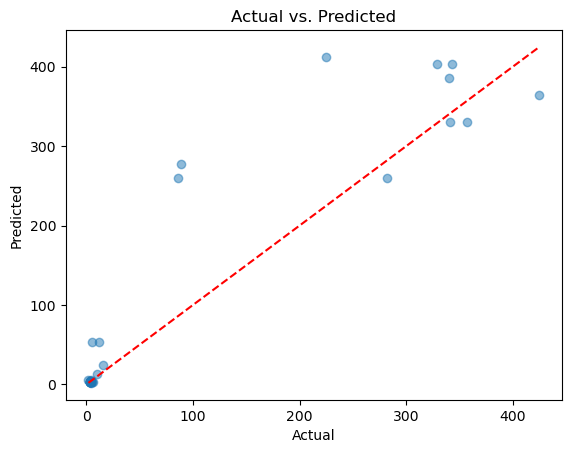

-------------------------------


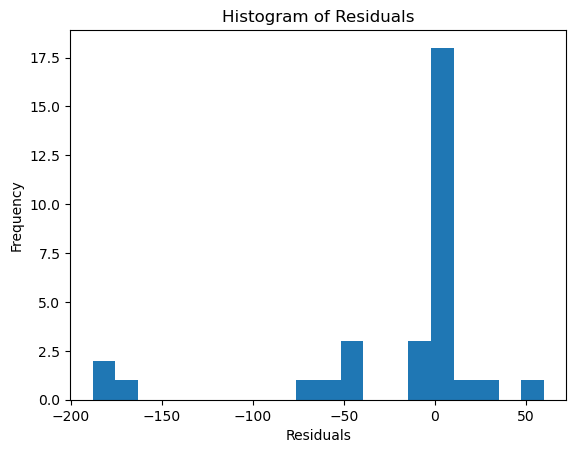

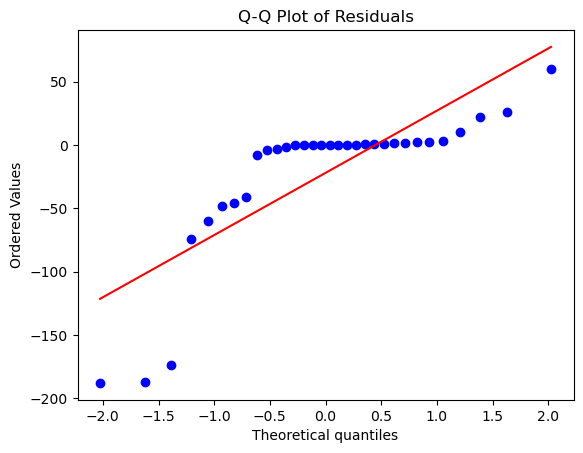

Williston
Number of data points:  0
No round03 model generated for Williston.
Michigan
Number of data points:  0
No round03 model generated for Michigan.
Pacific
Number of data points:  0
No round03 model generated for Pacific.
Illinois
Number of data points:  0
No round03 model generated for Illinois.
Great Plains
Number of data points:  0
No round03 model generated for Great Plains.
Anadarko
Number of data points:  0
No round03 model generated for Anadarko.
Rocky Mountain
Number of data points:  10
Best k value: 5
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 0.22222222222222224
MSE of the model: 5.826666666666668
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 2.41384893203089
MAE of the best KNN model: 2.066666666666667
-------------------------------
Quantile regres

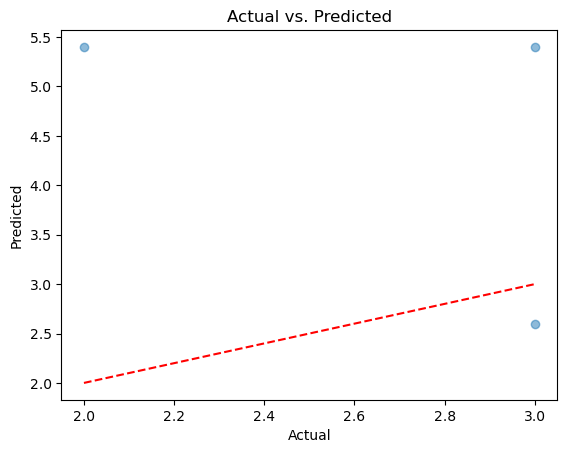

-------------------------------


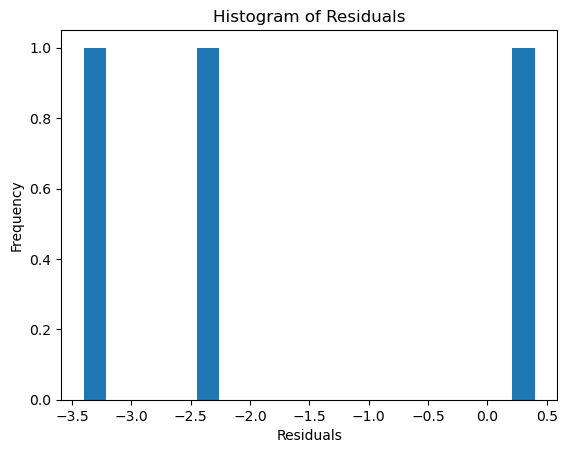

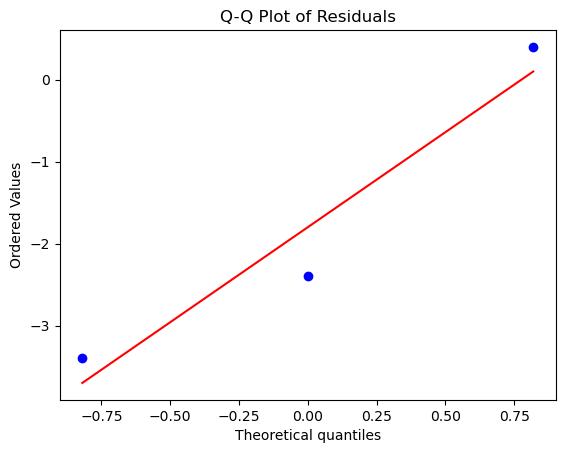

Fort Worth
Number of data points:  0
No round03 model generated for Fort Worth.


,round,basin,data_row_count,feature_quantity,feature_list,target_variable_variance,mse,rmse,mae,0.25_quantile_loss,0.5_quantile_loss,0.75_quantile_loss,%_of_results_within_5%,%_of_results_within_10%,%_of_results_within_15%,%_of_results_within_20%,%_of_results_within_50%,results_min%_difference,results_max%_difference,cross_val_mse
0,03,Gulf Coast,105,14,"[TDS, B, Ba, Br, HCO3, Ca, Cl, FeTot, K, Mg, N...",20133.56,3773.10,61.43,30.18,0.45,2.66,42.25,12.5,31.25,40.62,46.88,78.12,0.00,960.0,29339.61
1,03,Rocky Mountain,10,14,"[TDS, B, Ba, Br, HCO3, Ca, Cl, FeTot, K, Mg, N...",0.22,5.83,2.41,2.07,1.40,2.40,2.90,0.0,0.00,33.33,33.33,33.33,13.33,170.0,418.16


In [114]:
# Define all the variables...
df = df_data.copy()
round = '03'
basins = df_data['BASIN_CATEGORY'].unique()
all_columns = ['IDUSGS', 'PLAYTYPE', 'WELLTYPE', 'FORMSIMPLE', 'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY', 'PROVINCE', 'REGION', 'WELLNAME', 
               'API', 'DEPTHUPPER', 'DEPTHLOWER', 'PERIOD', 'DATESAMPLE', 'PH', 'B', 'Ba', 'Br', 'HCO3', 'Ca', 'Cl', 'FeTot', 'K', 'Li', 
               'Mg', 'Na', 'SO4', 'Sr', 'Zn', 'CHARGEBAL', 'BASIN_CATEGORY']
columns_to_keep = ['Li', 'B', 'Ba', 'Br', 'HCO3', 'Ca', 'Cl', 'FeTot', 'K', 'Mg', 'Na', 'SO4', 'Sr', 'Zn', 'BASIN_CATEGORY']
columns_to_drop = ['IDUSGS', 'PLAYTYPE', 'WELLTYPE', 'FORMSIMPLE', 'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY', 'PROVINCE', 'REGION', 
                   'WELLNAME', 'API', 'DEPTHUPPER', 'DEPTHLOWER', 'PERIOD', 'DATESAMPLE', 'PH', 'CHARGEBAL']
categorical_columns = [] # NONE for this round
test_size = 0.3
random_state = 42
k_values = list(range(1, 21))

# Run the function...
df_round03 = generate_knn_models_by_basin(df=df, round=round, basins=basins, columns_to_drop=columns_to_drop, categorical_columns=categorical_columns, 
                                          test_size=test_size, random_state=random_state, k_values=k_values)
df_round03

### ROUND 4

Appalachian
Number of data points:  262
Number of samples in the training dataset: 183


Best k value: 4
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 2696.54821312482
MSE of the model: 1747.875546458861
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 41.80760153918018
MAE of the best KNN model: 24.24701898734177
-------------------------------
Quantile regression loss:
Quantile 0.25: 6.587499999999999
Quantile 0.5: 11.599999999999994
Quantile 0.75: 24.2375
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 12.66%
±10%: 25.32%
±15%: 40.51%
±20%: 54.43%
±50%: 78.48%
Performance range: 281.80
Minimum percentage difference: 0.06%
Maximum percentage difference: 9155.41%
-------------------------------
Cross-validation MSE scores: [1455.67627669 1017.60829172 1813.35827872 1907.72676927 5869.37983594]
Mean cross-validation MSE: 24

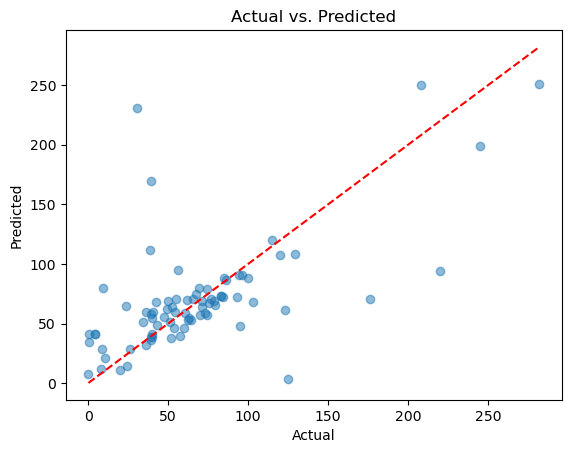

-------------------------------


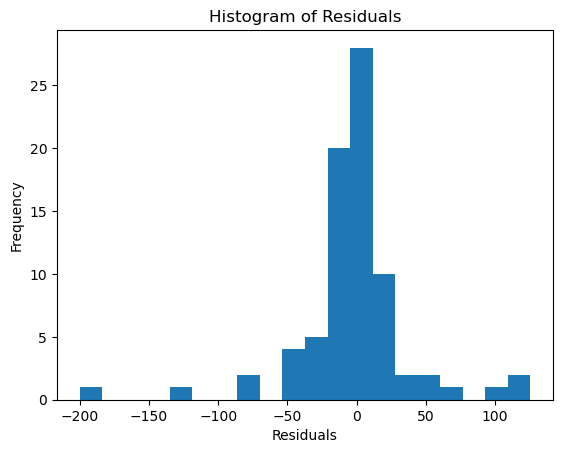

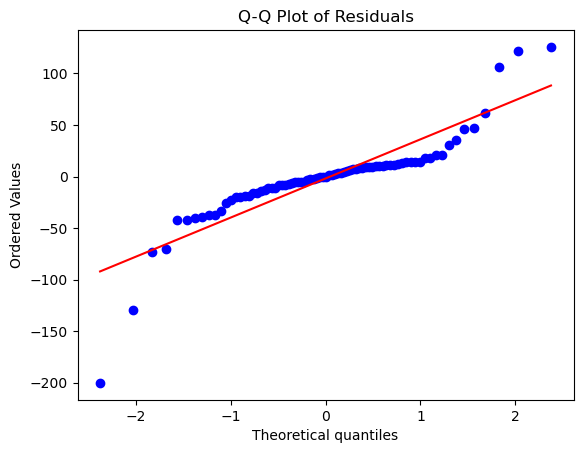

Permian
Number of data points:  229
Number of samples in the training dataset: 160
Best k value: 20
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 712.8004390674229
MSE of the model: 735.6512786992752
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 27.122892152188992
MAE of the best KNN model: 9.063065217391303
-------------------------------
Quantile regression loss:
Quantile 0.25: 2.3409999999999975
Quantile 0.5: 4.349000000000002
Quantile 0.75: 8.0595
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 11.59%
±10%: 18.84%
±15%: 33.33%
±20%: 44.93%
±50%: 84.06%
Performance range: 219.20
Minimum percentage difference: 1.86%
Maximum percentage difference: 328.77%
-------------------------------
Cross-validation MSE scores: [12

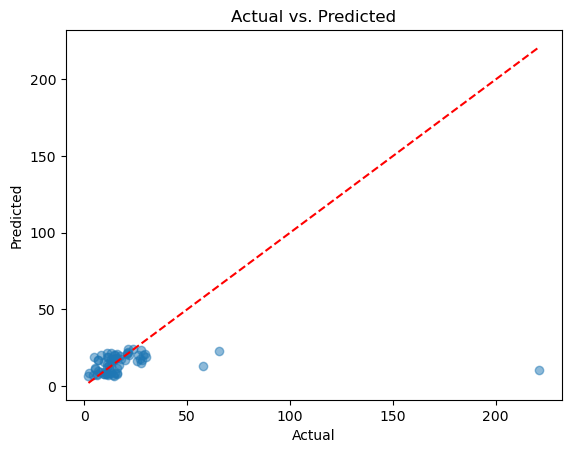

-------------------------------


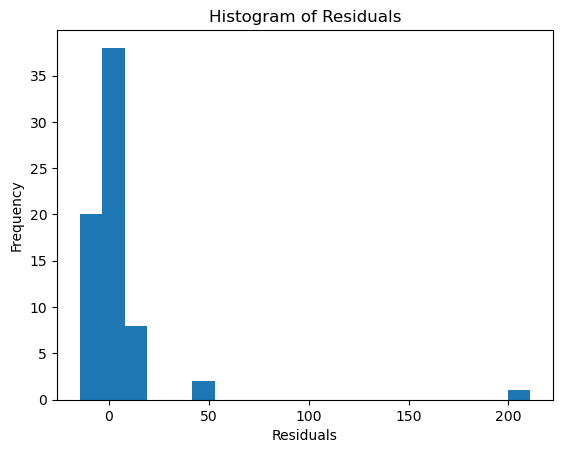

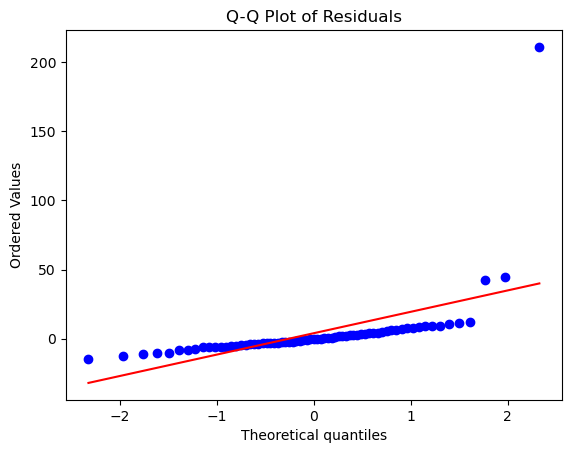

Oklahoma Platform
Number of data points:  99
Number of samples in the training dataset: 69
Best k value: 14
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 253.57762287666662
MSE of the model: 220.64178340663267
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 14.854015733350785
MAE of the best KNN model: 10.936302380952382
-------------------------------
Quantile regression loss:
Quantile 0.25: 3.641071428571428
Quantile 0.5: 8.532857142857143
Quantile 0.75: 12.823571428571427
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 10.00%
±10%: 16.67%
±15%: 26.67%
±20%: 33.33%
±50%: 70.00%
Performance range: 66.99
Minimum percentage difference: 1.71%
Maximum percentage difference: 929.61%
-------------------------------
Cross-validation MSE scor

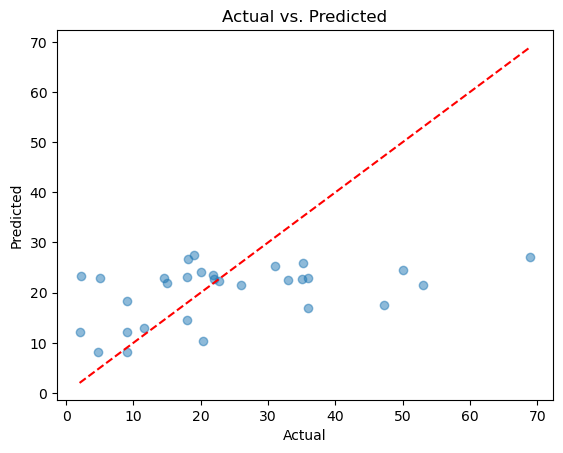

-------------------------------


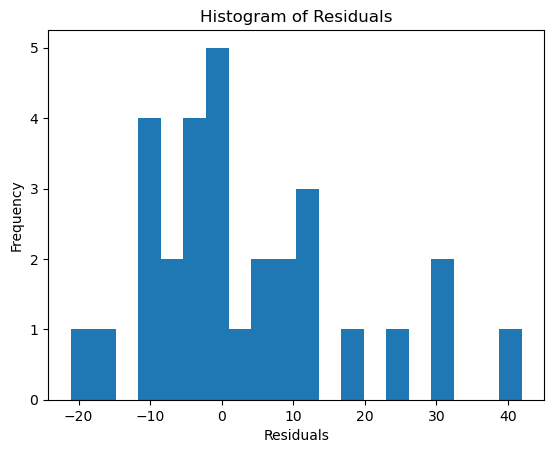

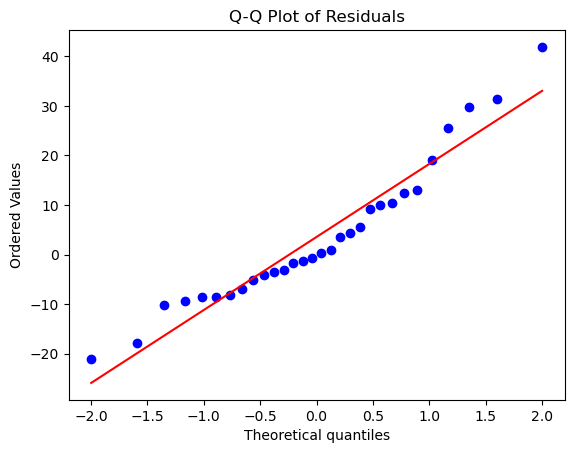

Gulf Coast
Number of data points:  650
Number of samples in the training dataset: 455
Best k value: 17
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 12620.483430297956
MSE of the model: 1985.098933859569
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 44.55444909164032
MAE of the best KNN model: 22.567837104072396
-------------------------------
Quantile regression loss:
Quantile 0.25: 1.7890961764705884
Quantile 0.5: 5.490588235294119
Quantile 0.75: 24.756728235294112
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 36.41%
±10%: 54.36%
±15%: 60.00%
±20%: 64.10%
±50%: 78.97%
Performance range: 466.20
Minimum percentage difference: 0.71%
Maximum percentage difference: 2338.66%
-------------------------------
Cross-validation MSE scores: 

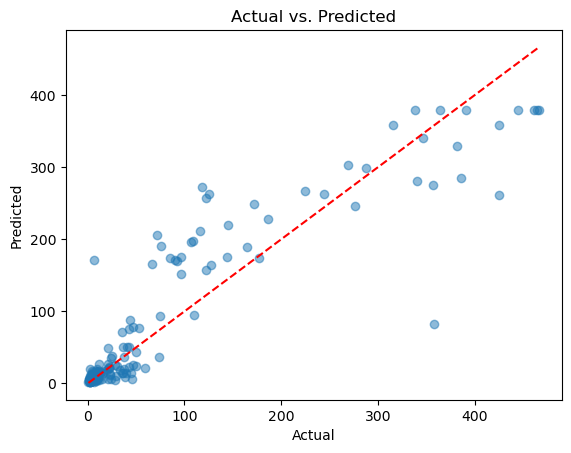

-------------------------------


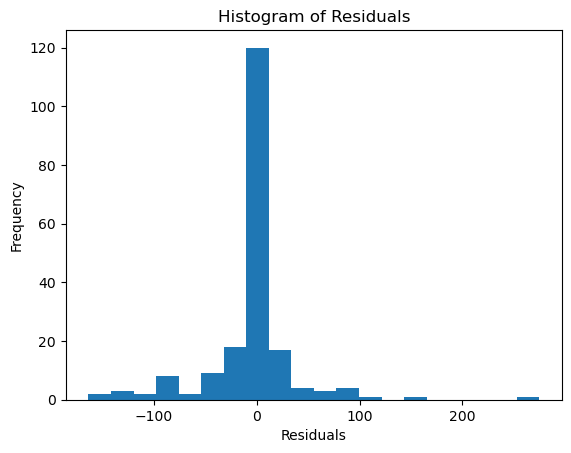

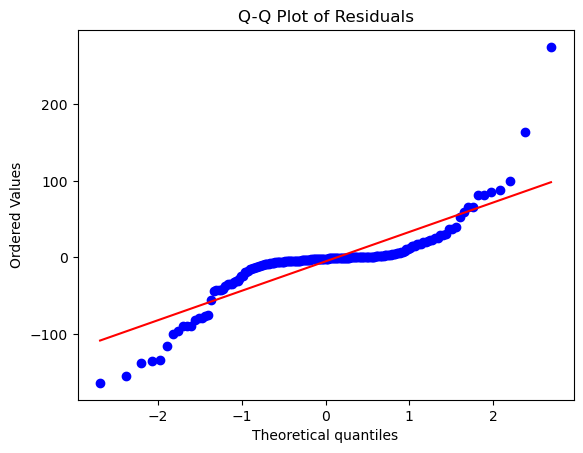

Williston
Number of data points:  64
Number of samples in the training dataset: 44
Best k value: 2
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 684.3349303593992
MSE of the model: 22.186423676627168
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 4.710246668342028
MAE of the best KNN model: 3.3752225000002496
-------------------------------
Quantile regression loss:
Quantile 0.25: 0.0499999999999996
Quantile 0.5: 3.3650000000000015
Quantile 0.75: 6.261499999999999
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 40.00%
±10%: 45.00%
±15%: 55.00%
±20%: 70.00%
±50%: 100.00%
Performance range: 76.31
Minimum percentage difference: 0.00%
Maximum percentage difference: 20468.29%
-------------------------------
Cross-validation MSE scores: [ 4

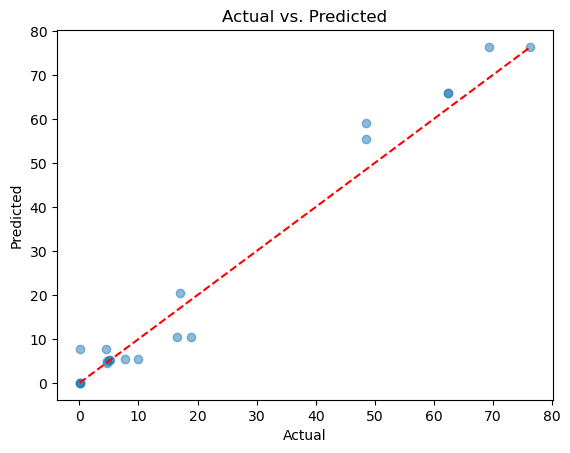

-------------------------------


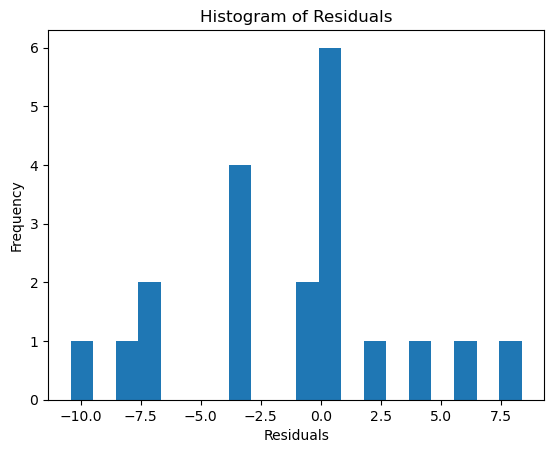

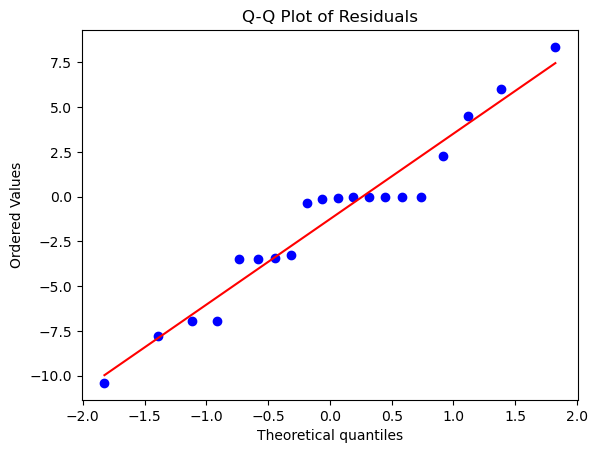

Michigan
Number of data points:  79
Number of samples in the training dataset: 55
Best k value: 7
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 657.7375414930556
MSE of the model: 299.746418962585
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 17.313186274126
MAE of the best KNN model: 8.14125
-------------------------------
Quantile regression loss:
Quantile 0.25: 1.6403571428571433
Quantile 0.5: 2.7121428571428554
Quantile 0.75: 7.450000000000003
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 20.83%
±10%: 50.00%
±15%: 62.50%
±20%: 66.67%
±50%: 83.33%
Performance range: 115.32
Minimum percentage difference: 0.40%
Maximum percentage difference: 62.62%
-------------------------------
Cross-validation MSE scores: [ 69.93975826  69.6650

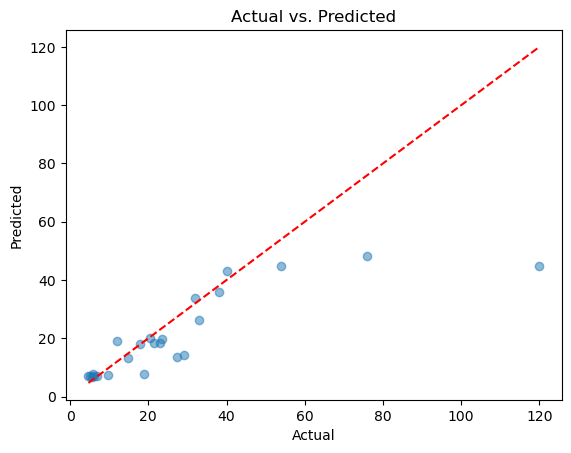

-------------------------------


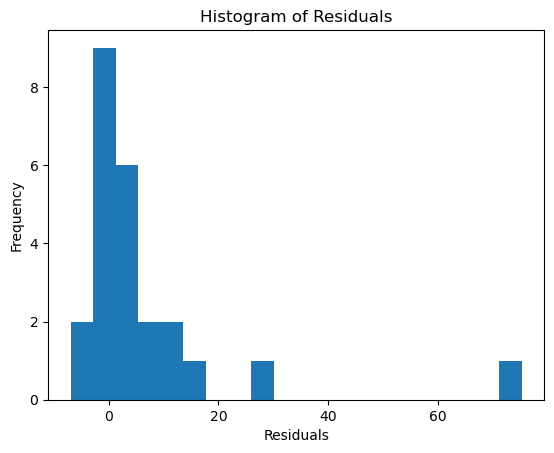

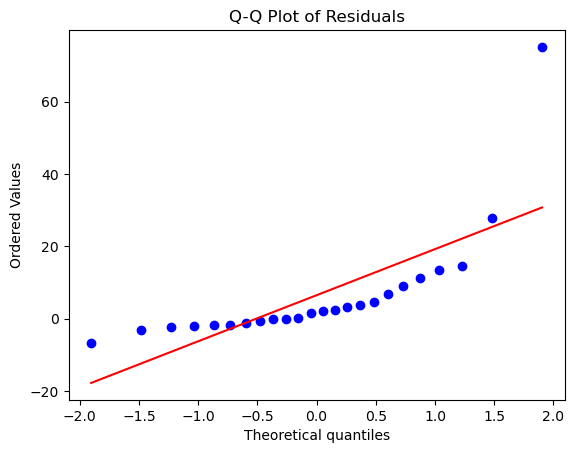

Pacific
Number of data points:  125
Number of samples in the training dataset: 87
Best k value: 3
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 4.364093351800554
MSE of the model: 7.30843764619883
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 2.703412222765672
MAE of the best KNN model: 1.320657894736842
-------------------------------
Quantile regression loss:
Quantile 0.25: 0.2783333333333334
Quantile 0.5: 0.5733333333333333
Quantile 0.75: 0.9950000000000001
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 10.53%
±10%: 23.68%
±15%: 26.32%
±20%: 36.84%
±50%: 73.68%
Performance range: 11.77
Minimum percentage difference: 4.61%
Maximum percentage difference: 837.73%
-------------------------------
Cross-validation MSE sco

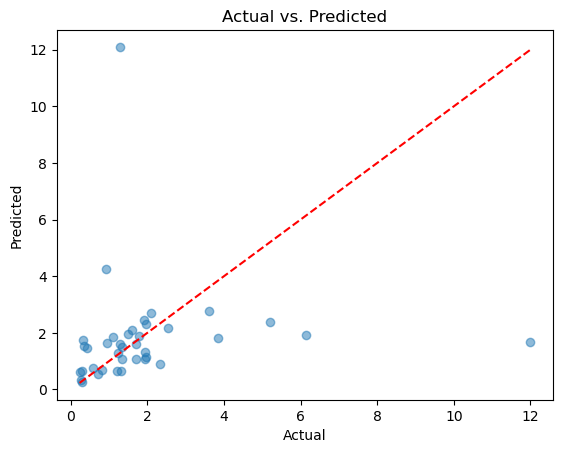

-------------------------------


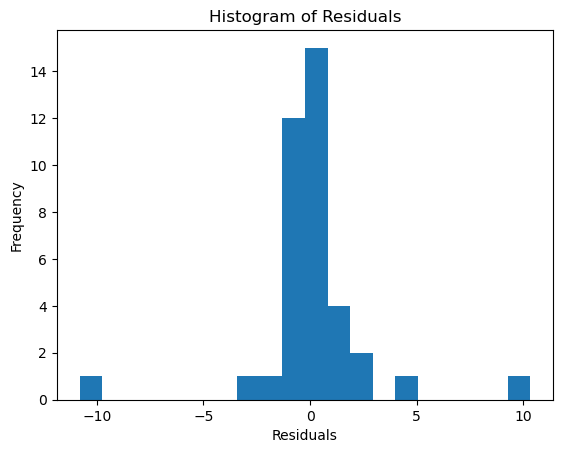

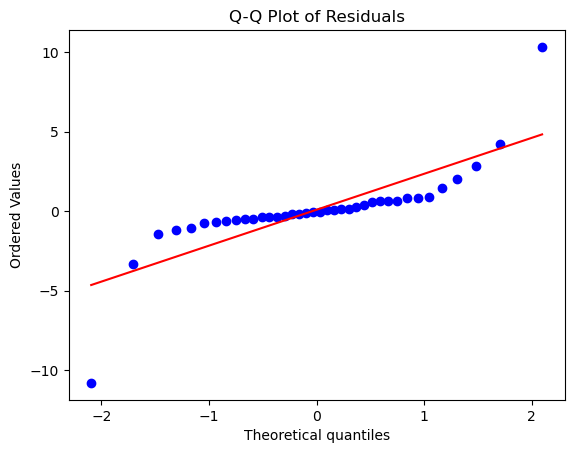

Illinois
Number of data points:  15
Number of samples in the training dataset: 10
Best k value: 3
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 19.014400000000002
MSE of the model: 22.35266666666666
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 4.727860686046773
MAE of the best KNN model: 3.8466666666666653
-------------------------------
Quantile regression loss:
Quantile 0.25: 2.43333333333333
Quantile 0.5: 3.0999999999999996
Quantile 0.75: 5.533333333333331
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 20.00%
±10%: 20.00%
±15%: 20.00%
±20%: 20.00%
±50%: 80.00%
Performance range: 12.00
Minimum percentage difference: 0.39%
Maximum percentage difference: 162.00%
-------------------------------
Cross-validation MSE sco

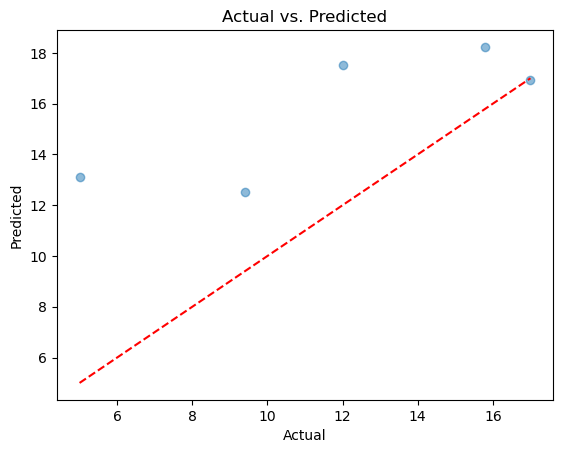

-------------------------------


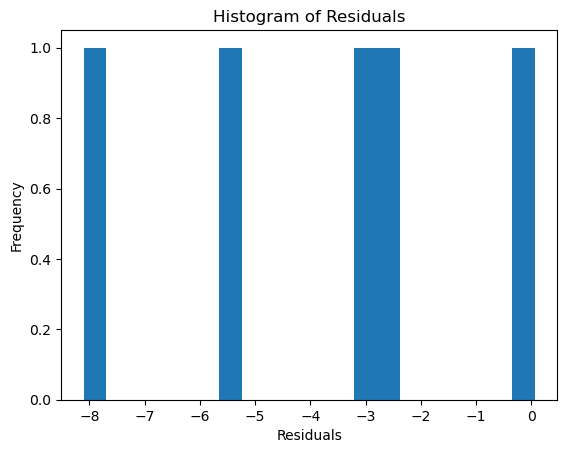

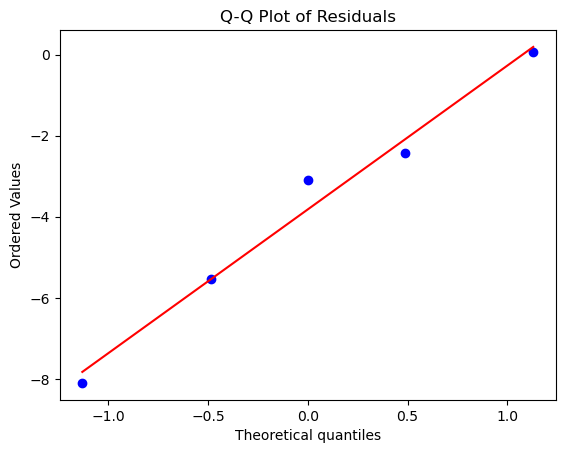

Great Plains
Number of data points:  22
Number of samples in the training dataset: 15
Best k value: 1
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 1.3165102040816326
MSE of the model: 0.2298571428571428
The model's MSE is smaller than the variance of the target variable.
The model is capturing a significant portion of the variability in the target variable.
RMSE of the model: 0.4794341903297498
MAE of the best KNN model: 0.2714285714285714
-------------------------------
Quantile regression loss:
Quantile 0.25: 0.04999999999999999
Quantile 0.5: 0.18000000000000005
Quantile 0.75: 0.19999999999999996
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 28.57%
±10%: 42.86%
±15%: 85.71%
±20%: 85.71%
±50%: 85.71%
Performance range: 3.49
Minimum percentage difference: 0.00%
Maximum percentage difference: 179.41%
-------------------------------
Cross-validation MSE scores

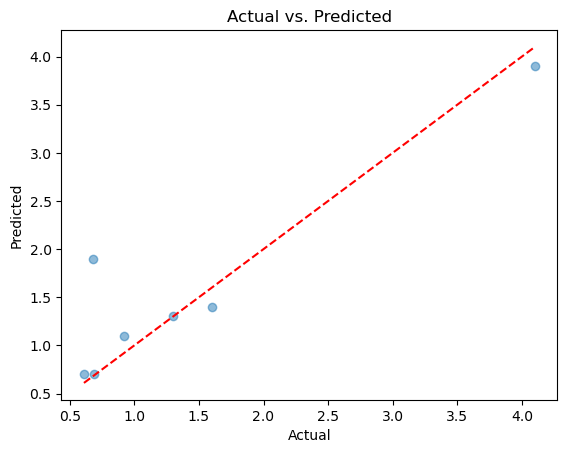

-------------------------------


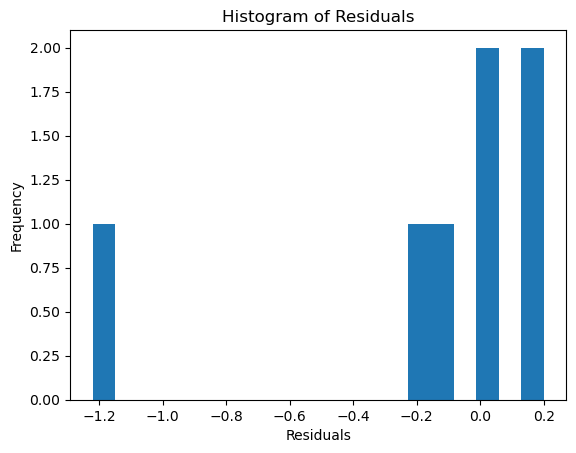

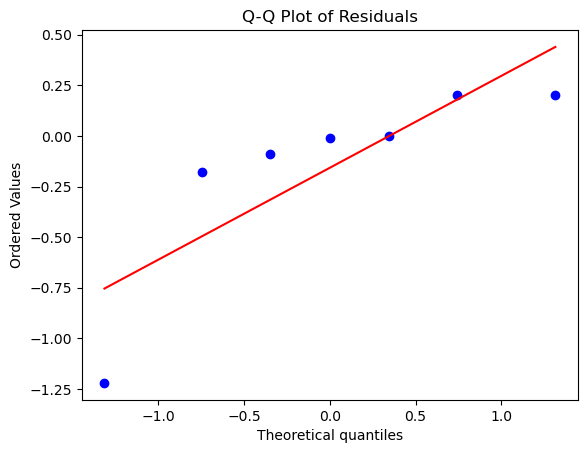

Anadarko
Number of data points:  59
Number of samples in the training dataset: 41
Best k value: 7
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 507.34303333333304
MSE of the model: 514.1967358276643
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 22.675906505091792
MAE of the best KNN model: 9.514603174603174
-------------------------------
Quantile regression loss:
Quantile 0.25: 2.6857142857142855
Quantile 0.5: 3.55
Quantile 0.75: 5.282142857142857
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 5.56%
±10%: 11.11%
±15%: 22.22%
±20%: 27.78%
±50%: 77.78%
Performance range: 100.55
Minimum percentage difference: 8.57%
Maximum percentage difference: 221.43%
-------------------------------
Cross-validation MSE scores: [210.49

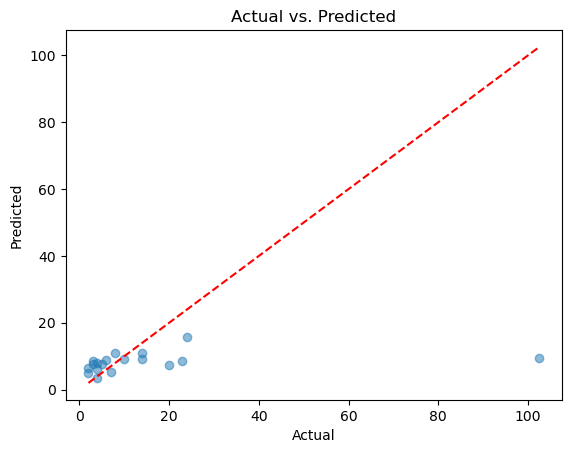

-------------------------------


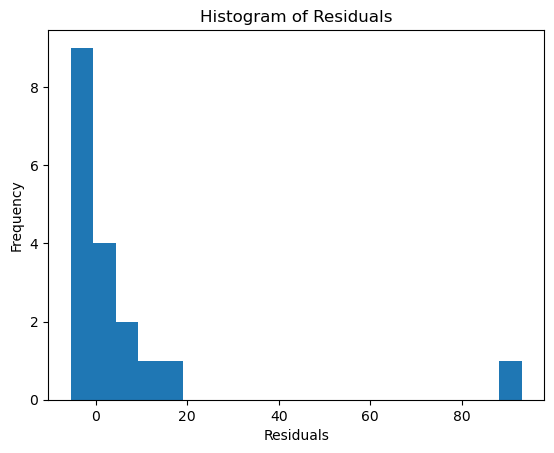

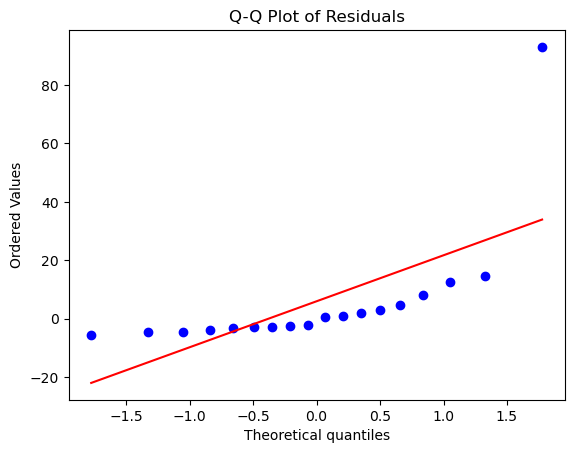

Rocky Mountain
Number of data points:  28
Number of samples in the training dataset: 19
Best k value: 3
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 31.624444444444446
MSE of the model: 420.7530135802469
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 20.51226495490556
MAE of the best KNN model: 15.040370370370368
-------------------------------
Quantile regression loss:
Quantile 0.25: 0.666666666666667
Quantile 0.5: 16.666666666666668
Quantile 0.75: 23.666666666666668
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 0.00%
±10%: 0.00%
±15%: 33.33%
±20%: 33.33%
±50%: 44.44%
Performance range: 19.00
Minimum percentage difference: 11.11%
Maximum percentage difference: 1675.67%
-------------------------------
Cross-validation

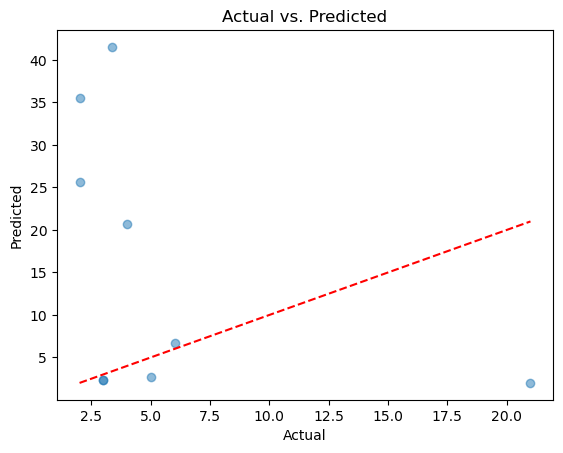

-------------------------------


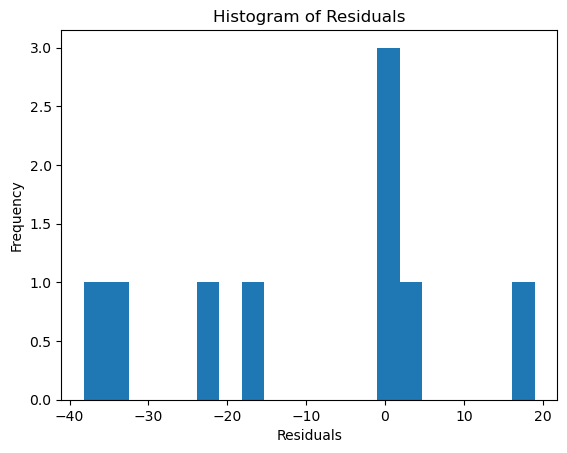

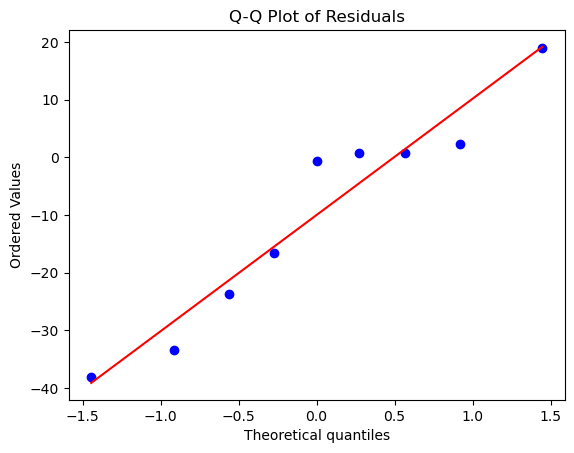

Fort Worth
Number of data points:  6
Number of samples in the training dataset: 4
Best k value: 2
-------------------------------
MODEL PERFORMANCE METRICS
-------------------------------
Variance of the target variable: 1482.25
MSE of the model: 2166.3414500000003
The model's MSE is close to or larger than the variance of the target variable.
The model's performance may be limited compared to the variability of the target variable.
RMSE of the model: 46.543973294079656
MAE of the best KNN model: 34.615
-------------------------------
Quantile regression loss:
Quantile 0.25: 19.0575
Quantile 0.5: 34.615
Quantile 0.75: 50.1725
-------------------------------
Percentage of predictions within different tolerance levels:
±5%: 0.00%
±10%: 50.00%
±15%: 50.00%
±20%: 50.00%
±50%: 50.00%
Performance range: 77.00
Minimum percentage difference: 58.33%
Maximum percentage difference: 79.19%
-------------------------------
Cross-validation MSE scores: [  1.5129   7.4529  15.6816 450.7129]
Mean cross

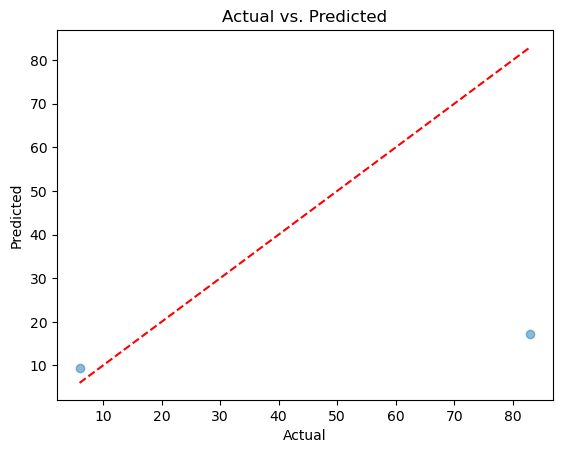

-------------------------------


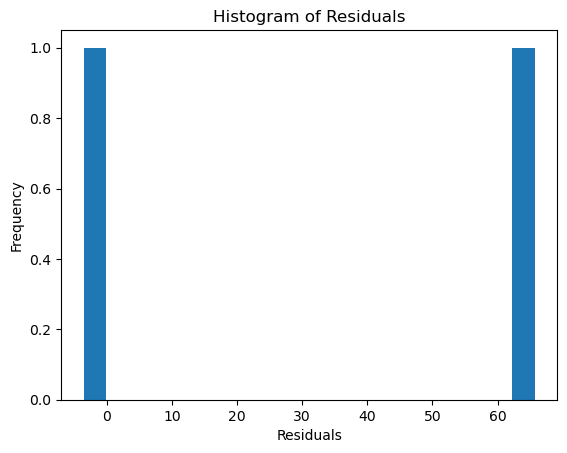

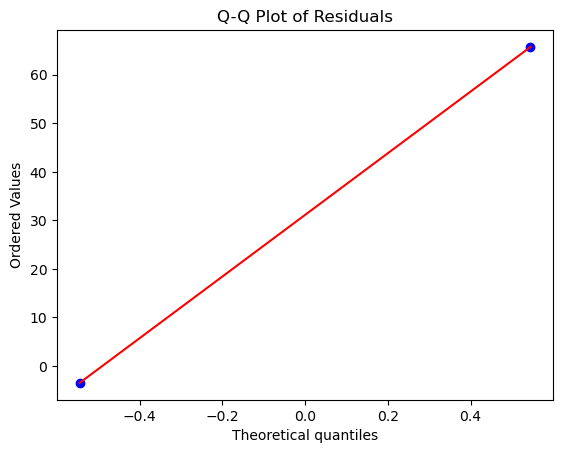

,round,basin,data_row_count,feature_quantity,feature_list,target_variable_variance,mse,rmse,mae,0.25_quantile_loss,0.5_quantile_loss,0.75_quantile_loss,%_of_results_within_5%,%_of_results_within_10%,%_of_results_within_15%,%_of_results_within_20%,%_of_results_within_50%,results_min%_difference,results_max%_difference,cross_val_mse
8,04,Great Plains,22,3,"[TDS, B, Br]",1.32,0.23,0.48,0.27,0.05,0.18,0.20,42.86,42.86,71.43,85.71,85.71,0.00,179.41,0.39
4,04,Williston,64,3,"[TDS, B, Br]",684.33,22.19,4.71,3.38,0.05,3.37,6.26,30.00,45.00,55.00,60.00,90.00,0.00,20468.29,83.29
0,04,Appalachian,262,3,"[TDS, B, Br]",2696.55,1747.88,41.81,24.25,6.59,11.60,24.24,12.66,20.25,40.51,51.90,75.95,0.06,9155.41,2412.75
5,04,Michigan,79,3,"[TDS, B, Br]",657.74,299.75,17.31,8.14,1.64,2.71,7.45,12.50,29.17,37.50,50.00,83.33,0.40,62.62,64.42
3,04,Gulf Coast,650,3,"[TDS, B, Br]",12620.48,1985.10,44.55,22.57,1.79,5.49,24.76,9.74,15.90,23.59,30.77,53.33,0.71,2338.66,6546.11
1,04,Permian,229,3,"[TDS, B, Br]",712.80,735.65,27.12,9.06,2.34,4.35,8.06,8.70,13.04,23.19,30.43,72.46,1.86,328.77,88.14
7,04,Illinois,15,3,"[TDS, B, Br]",19.01,22.35,4.73,3.85,2.43,3.10,5.53,20.00,20.00,20.00,40.00,80.00,0.39,162.00,35.03
2,04,Oklahoma Platform,99,3,"[TDS, B, Br]",253.58,220.64,14.85,10.94,3.64,8.53,12.82,6.67,13.33,16.67,26.67,63.33,1.71,929.61,228.55
6,04,Pacific,125,3,"[TDS, B, Br]",4.36,7.31,2.70,1.32,0.28,0.57,1.00,5.26,7.89,15.79,23.68,60.53,4.61,837.73,7.85
9,04,Anadarko,59,3,"[TDS, B, Br]",507.34,514.20,22.68,9.51,2.69,3.55,5.28,0.00,5.56,11.11,11.11,44.44,8.57,221.43,70.96


In [142]:
# Define all the variables...
df = df_data.copy()
round = '04'
basins = df_data['BASIN_CATEGORY'].unique()
all_columns = ['IDUSGS', 'PLAYTYPE', 'WELLTYPE', 'FORMSIMPLE', 'TDS', 'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY', 'PROVINCE', 'REGION', 
               'WELLNAME', 'API', 'DEPTHUPPER', 'DEPTHLOWER', 'PERIOD', 'DATESAMPLE', 'PH', 'B', 'Ba', 'Br', 'HCO3', 'Ca', 'Cl', 'FeTot', 
               'K', 'Li', 'Mg', 'Na', 'SO4', 'Sr', 'Zn', 'CHARGEBAL', 'BASIN_CATEGORY']
columns_to_keep = ['Li', 'TDS', 'B', 'Br', 'BASIN_CATEGORY'] # TDS, B, Br were top 3 PC's for Gulf Coast Basin
columns_to_drop = ['IDUSGS', 'PLAYTYPE', 'WELLTYPE', 'FORMSIMPLE', 'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY', 'PROVINCE', 'REGION', 
                   'WELLNAME', 'API', 'DEPTHUPPER', 'DEPTHLOWER', 'PERIOD', 'DATESAMPLE', 'PH', 'Ba', 'HCO3', 'Ca', 'Cl', 'FeTot', 
                   'K', 'Mg', 'Na', 'SO4', 'Sr', 'Zn', 'CHARGEBAL']
categorical_columns = [] # NONE for this round
test_size = 0.3
random_state = 42
k_values = list(range(1, 21))

# Run the function...
df_round04 = generate_knn_models_by_basin(df=df, round=round, basins=basins, columns_to_drop=columns_to_drop, categorical_columns=categorical_columns, 
                                          test_size=test_size, random_state=random_state, k_values=k_values)
df_round04

### ROUND 5

### ROUND 6

### ROUND 7

## <ins>Merge all results dfs into 1 large df for evaluation

In [ ]:
rounds = [df_round01, '''...''']
columns = ['round', 'basin', 'data_row_count','feature_quantity', 'feature_list', 'target_variable_variance', 'mse', 'rmse', 'mae', 
               '0.25_quantile_loss', '0.5_quantile_loss', '0.75_quantile_loss', '%_of_results_within_5%', '%_of_results_within_10%', '%_of_results_within_15%', 
               '%_of_results_within_20%', '%_of_results_within_50%', 'results_min%_difference', 'results_max%_difference','cross_val_mse']

for round in rounds:
    df_results = #...
    

In [ ]:
# Identify best round # for each basin
basins = df_data['BASIN_CATEGORY'].unique()

for basin in basins:
    #...